In [424]:
# Maths
import numpy as np
import pandas as pd
import geopandas as gpd
import scipy.stats as stats
from scipy.stats import binom, norm
import math

# Bayesian Stuff
import pymc as pm
import arviz as az

# Plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
sns.set_style('whitegrid')

# Read in Norwegian EV Registration Data

In [544]:
df = pd.read_csv('../../data/vehicle_data/norway_vehicle_registrations.csv').dropna().set_index('Year', drop=False)
df['Year_Datetime'] = pd.to_datetime(df['Year'].astype(str), format='%Y')
df

Year  BEV_Stock  PHEV_Stock  EV_Fleet  ICEV_Stock  Total_Stock  \
Year                                                                   
2009  2009       1388           0      1388   2311945.0    2314721.0   
2010  2010       1782           0      1782   2225718.0    2229282.0   
2011  2011       3982           1      3983   2338370.0    2346336.0   
2012  2012       6543         341      6884   2416449.0    2430217.0   
2013  2013      18000        3034     21034   2478966.0    2521034.0   
2014  2014      39000        7106     46106   2502914.0    2595126.0   
2015  2015      69000       33455    102455   2511181.0    2716091.0   
2016  2016      97532       34514    132046   2532763.0    2796855.0   
2017  2017     138983       67317    206300   2513524.0    2926124.0   
2018  2018     195348       96150    291498   2459882.0    3042878.0   
2019  2019     260689      116028    376717   2423380.0    3176814.0   
2020  2020     343707      120662    464369   2470789.0    3399527.0   
2021  2021     465410      177490    642900   2359745.0    3645545.0   
2022  2022     512979      187923    700902   2359832.0    3761636.0   

      BEV_Stock_Share_Total  PHEV_Stock_Share_Total  EV_Stock_Share_Total  \
Year                                                                        
2009                 0.0006                  0.0000                0.0006   
2010                 0.0008                  0.0000                0.0008   
2011                 0.0017                  0.0000                0.0017   
2012                 0.0027                  0.0001                0.0028   
2013                 0.0072                  0.0012                0.0084   
2014                 0.0153                  0.0028                0.0181   
2015                 0.0264                  0.0128                0.0392   
2016                 0.0366                  0.0130                0.0496   
2017                 0.0511                  0.0248                0.0759   
2018                 0.0710                  0.0349                0.1059   
2019                 0.0931                  0.0414                0.1345   
2020                 0.1171                  0.0411                0.1582   
2021                 0.1550                  0.0591                0.2141   
2022                 0.1676                  0.0614                0.2290   

      ICEV_Stock_Share_Total  ...  EV_New_Registrations  \
Year                          ...                         
2009                  0.9994  ...                   145   
2010                  0.9992  ...                   380   
2011                  0.9983  ...                  2010   
2012                  0.9972  ...                  4596   
2013                  0.9916  ...                  8364   
2014                  0.9819  ...                 19697   
2015                  0.9608  ...                 33408   
2016                  0.9504  ...                 44530   
2017                  0.9241  ...                 61980   
2018                  0.8941  ...                 72650   
2019                  0.8655  ...                 79420   
2020                  0.8418  ...                105559   
2021                  0.7859  ...                151776   
2022                  0.7710  ...                154416   

      ICEV_New_Registrations  Total_New_Registrations  \
Year                                                    
2009                131673.0                 131818.0   
2010                126287.0                 126667.0   
2011                136542.0                 138552.0   
2012                133586.0                 138182.0   
2013                141636.0                 150000.0   
2014                130295.0                 149992.0   
2015                125195.0                 158603.0   
2016                115833.0                 160363.0   
2017                105722.0                 167702.0   
2018                 86189.0                 158

# Preliminary Data Exploration

<Axes: xlabel='Year'>

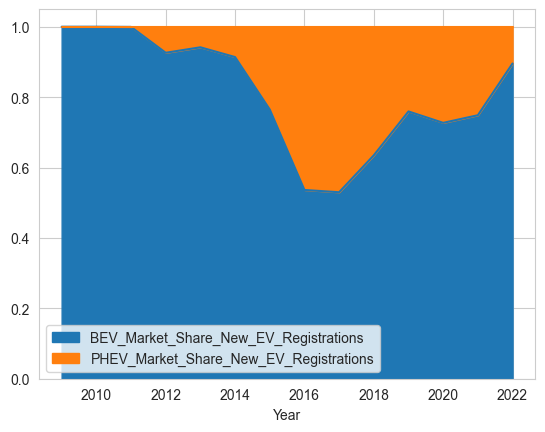

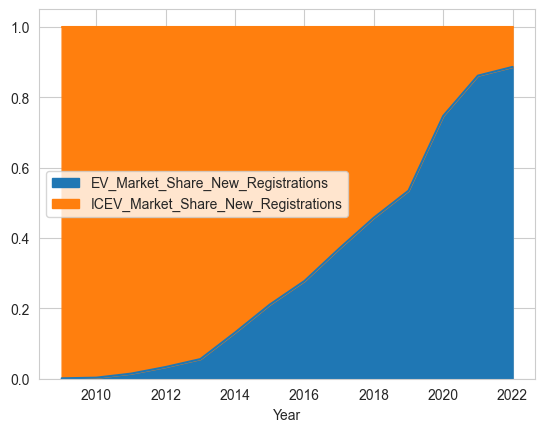

In [68]:
df[['BEV_Market_Share_New_EV_Registrations', 'PHEV_Market_Share_New_EV_Registrations']].plot.area()
df[['EV_Market_Share_New_Registrations', 'ICEV_Market_Share_New_Registrations']].plot.area()

# "Global" Variables

In [1034]:
t_max = 2016
horizon = 2030

icev_ban = 2025
phev_ban = 2025

bev_lifetime = 20
phev_lifetime = 20
icev_lifetime = 20

# Linear Projection for Sales Share

<Axes: xlabel='Year'>

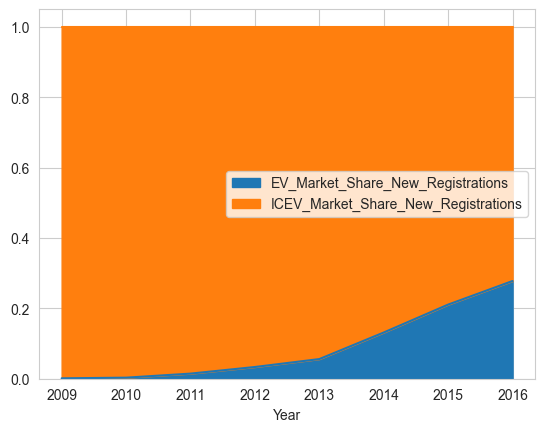

In [70]:
df.loc[:t_max, ['EV_Market_Share_New_Registrations', 'ICEV_Market_Share_New_Registrations']].plot.area()

In [190]:
def project_sales_share(df, ban, value_at_ban):
    
    date_range = np.arange(df.index.values[0], horizon+1) # Current and Future Dates
    df = df.reindex(date_range)

    # Linear Interpolation
    df.loc[ban] = value_at_ban # 0 if banned vehicle type, 1 if beneficiary.
    df = df.interpolate()
    return df

# Sales Share Projection with Gaussian Processes

In [458]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

dates = np.array([t_max, icev_ban])

X_train = dates.reshape(-1, 1)

def train_gp(df):

    y_train = df.loc[[t_max, icev_ban]].values.reshape(-1,1)

    kernel = 1 * RBF(length_scale=1, length_scale_bounds=(1e-2, 1e3))
    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100)
    gaussian_process.fit(X_train, y_train)
    
    return gaussian_process

### Add Projected Datapoint at the ICEV and PHEV Ban Date

In [1032]:
ev_sales_share = project_sales_share(df.loc[:t_max, 'EV_Market_Share_New_Registrations'], icev_ban, 1)
bev_sales_share = project_sales_share(df.loc[:t_max, 'BEV_Market_Share_New_EV_Registrations'], phev_ban, 1)

In [1033]:
ev_share_gp = train_gp(ev_sales_share)
bev_share_gp = train_gp(bev_sales_share)

# Experimenting with Gaussian Process Regression for Sales Share Projection

In [997]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

dates = np.array([t_max, icev_ban])

X_train = dates.reshape(-1, 1)
y_train = ev_sales_share.loc[[t_max, icev_ban]].values.reshape(-1,1)

kernel = 1 * RBF(length_scale=10, length_scale_bounds=(1e-2, 1e3))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

0.734**2 * RBF(length_scale=7.82)

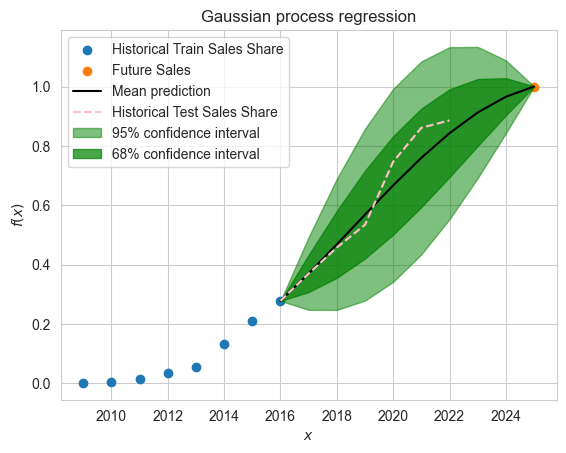

In [998]:
X = np.arange(t_max, icev_ban + 1).reshape(-1,1)
    
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

plt.scatter(np.arange(2009, t_max+1).reshape(-1,1), ev_sales_share.loc[:t_max].values.reshape(-1, 1), label='Historical Train Sales Share')
plt.scatter(X_train[-1], y_train[-1], label="Future Sales")
plt.plot(X, mean_prediction, label="Mean prediction", color='black')
plt.plot(df['EV_Market_Share_New_Registrations'].loc[t_max:].index, df['EV_Market_Share_New_Registrations'].loc[t_max:].values, color='pink', linestyle='--', label='Historical Test Sales Share')

plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    color='green',
    label=r"95% confidence interval",
)
plt.fill_between(
    X.ravel(),
    mean_prediction - 1 * std_prediction,
    mean_prediction + 1 * std_prediction,
    alpha=0.7,
    color='green',
    label=r"68% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression")

In [440]:
n_samples = 100
gp_samples = gaussian_process.sample_y(X, n_samples)

In [245]:
X

array([[2016],
       [2017],
       [2018],
       [2019],
       [2020],
       [2021],
       [2022],
       [2023],
       [2024],
       [2025]])

In [249]:
gp_samples_df = pd.DataFrame(index=np.arange(t_max, icev_ban + 1), columns=range(0, n_samples), data=gp_samples)
gp_samples_df

0         1         2         3         4         5         6   \
2016  0.277599  0.277613  0.277589  0.277610  0.277589  0.277604  0.277586   
2017  0.260416  0.340379  0.516066  0.351523  0.451852  0.416197  0.413516   
2018  0.266166  0.423339  0.739003  0.441388  0.610451  0.558279  0.548515   
2019  0.301750  0.522858  0.932428  0.540105  0.745854  0.693918  0.673740   
2020  0.369826  0.632492  1.084293  0.640933  0.852613  0.814089  0.782442   
2021  0.468282  0.743455  1.185059  0.737928  0.928360  0.911416  0.870335   
2022  0.590632  0.845501  1.228173  0.826121  0.974438  0.980626  0.935503   
2023  0.727248  0.928132  1.210526  0.901433  0.995946  1.018715  0.977941   
2024  0.867158  0.981960  1.132858  0.960426  1.001105  1.024832  0.998864   
2025  1.000013  1.000008  1.000010  1.000007  0.999994  0.999997  0.999991   

            7         8         9   ...        90        91        92  \
2016  0.277589  0.277621  0.277606  ...  0.277609  0.277606  0.277614   
2017  0.326598  0.426894  0.375897  ...  0.470312  0.443823  0.432028   
2018  0.386767  0.579361  0.487729  ...  0.644839  0.589641  0.587919   
2019  0.459046  0.724826  0.607024  ...  0.794124  0.711704  0.737489   
2020  0.543226  0.853683  0.725583  ...  0.912678  0.809395  0.871570   
2021  0.637328  0.957296  0.833912  ...  0.997078  0.884241  0.980339   
2022  0.737202  1.028337  0.922444  ...  1.046151  0.938873  1.054284   
2023  0.836496  1.061129  0.982909  ...  1.060882  0.975809  1.085318   
2024  0.927094  1.052055  1.009559  ...  1.044092  0.996368  1.067903   
2025  0.999999  0.999995  0.999994  ...  0.999984  0.999993  0.999982   

            93        94        95        96        97        98        99  
2016  0.277588  0.277605  0.277607  0.277600  0.277594  0.277601  0.277602  
2017  0.278193  0.329578  0.427132  0.378348  0.395460  0.349942  0.338365  
2018  0.297559  0.401444  0.570592  0.489611  0.521276  0.430508  0.413980  
2019  0.338895  0.492279  0.703092  0.606191  0.648549  0.517742  0.500799  
2020  0.404177  0.596894  0.819711  0.720979  0.769255  0.608830  0.594265  
2021  0.493428  0.706663  0.915479  0.825731  0.874539  0.700184  0.689405  
2022  0.604176  0.811094  0.985481  0.912139  0.955793  0.788027  0.781351  
2023  0.731180  0.899805  1.025140  0.972981  1.005952  0.868937  0.865816  
2024  0.866510  0.964423  1.030728  1.003097  1.020800  0.940217  0.939443  
2025  0.999998  0.999999  1.000005  1.000000  0.999999  0.999994  0.999996  

[10 rows x 100 columns]

<Axes: >

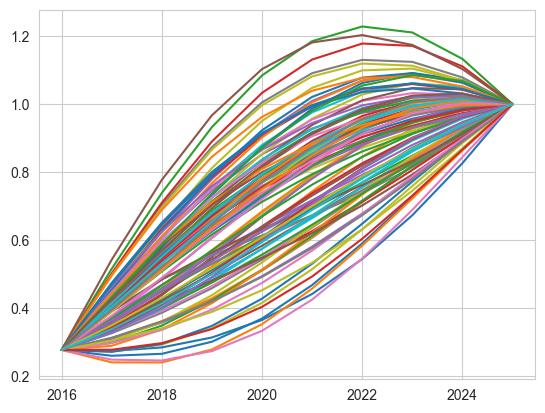

In [251]:
gp_samples_df.plot(legend=False)

In [221]:
mean_prediction

array([0.2776    , 0.36999975, 0.46805015, 0.56832092, 0.66692772,
       0.75977636, 0.84284174, 0.91245558, 0.96557429, 1.        ])

In [220]:
std_prediction

array([1.00000004e-05, 6.25628448e-02, 1.12728910e-01, 1.47802022e-01,
       1.65844873e-01, 1.65844873e-01, 1.47802022e-01, 1.12728910e-01,
       6.25628448e-02, 1.00000004e-05])

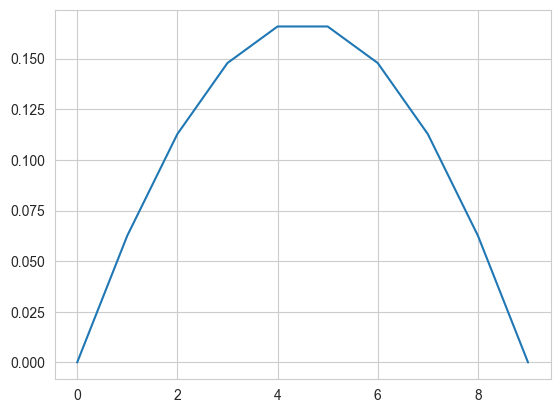

In [296]:
plt.plot(std_prediction)

# Truncating the Distributions

So that the sales share is never projected to go above 1.

In [253]:
1 - mean_prediction # Upper limit for 'SD'

array([7.22400000e-01, 6.30000248e-01, 5.31949847e-01, 4.31679083e-01,
       3.33072280e-01, 2.40223641e-01, 1.57158256e-01, 8.75444185e-02,
       3.44257056e-02, 2.16699214e-10])

In [254]:
(1 - mean_prediction)/std_prediction # Upper limit for multiples of SD

array([7.22399970e+04, 1.00698785e+01, 4.71884138e+00, 2.92065750e+00,
       2.00833631e+00, 1.44848398e+00, 1.06330248e+00, 7.76592431e-01,
       5.50257996e-01, 2.16699205e-05])

In [255]:
a = (1 - mean_prediction)/std_prediction # Upper Limit for Projections

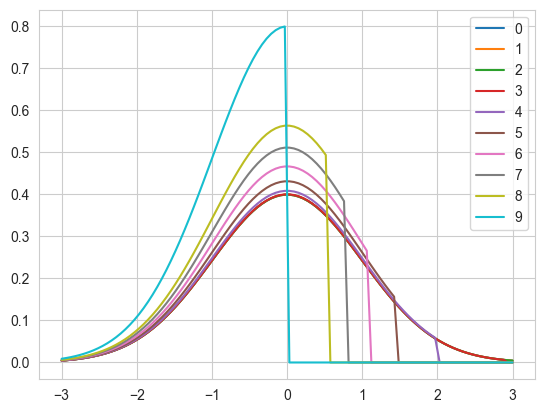

In [260]:
mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

fig, ax = plt.subplots()

for i in range(0, len(X)):
    ax.plot(x, stats.truncnorm.pdf(x, mu - 3*sigma, a[i]), label = '{}'.format(i))
plt.legend()
plt.show()

1. Generate `n_samples` random numbers between 0 and 1.
2. Feed these into a Percentile-Point Function that returns a random variable who's probability is less-than or equal to an input probability value.
3. Sort these random variables in order of size.

In [436]:
gp_sd_truncated = np.zeros([len(X), n_samples])
for i in range(0, len(X)):
    gp_sd_truncated[i] = np.sort(stats.truncnorm.ppf(np.random.rand(n_samples), mu - 3*sigma, a[i]))

In [437]:
gp_sd_truncated

array([[-2.84120821e+00, -2.63217957e+00, -2.61006355e+00, ...,
         2.79852904e+00,  2.94647095e+00,  2.95979819e+00],
       [-2.92385866e+00, -2.72126285e+00, -2.68246640e+00, ...,
         3.28877342e+00,  3.42907810e+00,  3.80622956e+00],
       [-2.85415101e+00, -2.72886802e+00, -2.71300922e+00, ...,
         2.39934275e+00,  2.49062191e+00,  2.60069309e+00],
       ...,
       [-2.92381877e+00, -2.84870561e+00, -2.82008631e+00, ...,
         7.71052354e-01,  7.71461256e-01,  7.74842940e-01],
       [-2.91417233e+00, -2.89930614e+00, -2.89655896e+00, ...,
         5.34561428e-01,  5.45221678e-01,  5.50130099e-01],
       [-2.96177108e+00, -2.85366472e+00, -2.80979145e+00, ...,
        -6.57118688e-03, -3.21586776e-03, -2.18264311e-04]])

In [438]:
gp_sd_truncated_df = pd.DataFrame(index=np.arange(t_max, icev_ban + 1), columns=range(0, n_samples), data= gp_sd_truncated)
gp_sd_truncated_df

0         1         2         3         4         5         6    \
2016 -2.841208 -2.632180 -2.610064 -2.485018 -2.397981 -2.392854 -2.317969   
2017 -2.923859 -2.721263 -2.682466 -2.663051 -2.601037 -2.574985 -2.537835   
2018 -2.854151 -2.728868 -2.713009 -2.707504 -2.655948 -2.602142 -2.518206   
2019 -2.969165 -2.839320 -2.649860 -2.610677 -2.596054 -2.559550 -2.535479   
2020 -2.932278 -2.767076 -2.688076 -2.639187 -2.497080 -2.493213 -2.472200   
2021 -2.980612 -2.891692 -2.878232 -2.712615 -2.644794 -2.584083 -2.561793   
2022 -2.958415 -2.908076 -2.899186 -2.755724 -2.717149 -2.652074 -2.611435   
2023 -2.923819 -2.848706 -2.820086 -2.776014 -2.695333 -2.674637 -2.521721   
2024 -2.914172 -2.899306 -2.896559 -2.834257 -2.538357 -2.526835 -2.505745   
2025 -2.961771 -2.853665 -2.809791 -2.749491 -2.743575 -2.728291 -2.681168   

           7         8         9    ...       990       991       992  \
2016 -2.306664 -2.270978 -2.237892  ...  2.556519  2.582728  2.622290   
2017 -2.442920 -2.348435 -2.333708  ...  2.291430  2.355882  2.529040   
2018 -2.500855 -2.422306 -2.280821  ...  2.153169  2.157844  2.194814   
2019 -2.395454 -2.394071 -2.265428  ...  2.361247  2.441245  2.451937   
2020 -2.413103 -2.401539 -2.319401  ...  1.835095  1.842890  1.843648   
2021 -2.446419 -2.407670 -2.385901  ...  1.394197  1.394227  1.394902   
2022 -2.567406 -2.539607 -2.504253  ...  1.018335  1.022098  1.027188   
2023 -2.500476 -2.495894 -2.445118  ...  0.758142  0.759885  0.760545   
2024 -2.404016 -2.402137 -2.359246  ...  0.518309  0.522423  0.525618   
2025 -2.654413 -2.622468 -2.581290  ... -0.014842 -0.014578 -0.013044   

           993       994       995       996       997       998       999  
2016  2.626166  2.655912  2.669846  2.696698  2.798529  2.946471  2.959798  
2017  2.557511  2.842244  2.991009  2.996256  3.288773  3.429078  3.806230  
2018  2.284437  2.331498  2.352641  2.360478  2.399343  2.490622  2.600693  
2019  2.455271  2.465943  2.470504  2.561228  2.603555  2.614849  2.664324  
2020  1.874972  1.878071  1.912368  1.928262  1.948381  1.972282  1.977662  
2021  1.407576  1.419709  1.425078  1.430193  1.435813  1.438529  1.448204  
2022  1.033924  1.035338  1.037077  1.044782  1.054415  1.062418  1.063245  
2023  0.763253  0.769291  0.769387  0.770707  0.771052  0.771461  0.774843  
2024  0.530459  0.533141  0.533978  0.534020  0.534561  0.545222  0.550130  
2025 -0.011652 -0.009729 -0.008468 -0.008443 -0.006571 -0.003216 -0.000218  

[10 rows x 1000 columns]

<Axes: >

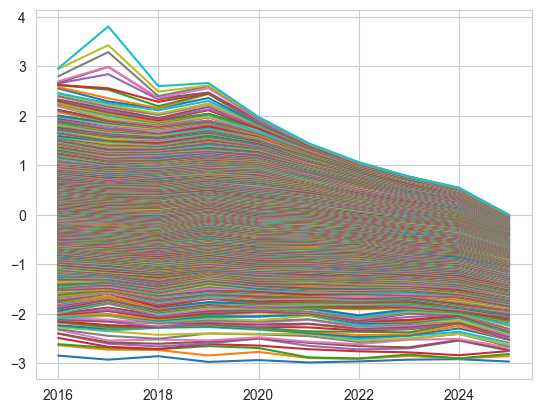

In [439]:
gp_sd_truncated_df.plot(legend=False)

In [445]:
gp_truncated = np.zeros([len(X), n_samples])
for i in range(0, len(X)):
    gp_truncated[i] = mean_prediction[i] + std_prediction[i]*np.sort(stats.truncnorm.ppf(np.random.rand(n_samples), mu - 3*sigma, a[i]))

In [446]:
gp_truncated_df = pd.DataFrame(index=np.arange(t_max, icev_ban + 1), columns=range(0, n_samples), data= gp_truncated)
gp_truncated_df

0         1         2         3         4         5         6   \
2016  0.277576  0.277581  0.277583  0.277585  0.277586  0.277587  0.277587   
2017  0.184030  0.240025  0.244428  0.245294  0.249264  0.254113  0.255560   
2018  0.204957  0.237915  0.244790  0.262458  0.296877  0.306052  0.306263   
2019  0.201767  0.248306  0.284955  0.329327  0.332992  0.338766  0.377094   
2020  0.303400  0.344518  0.375309  0.400293  0.434005  0.454466  0.456833   
2021  0.321690  0.363055  0.400605  0.446928  0.449488  0.476095  0.480067   
2022  0.521641  0.538184  0.568368  0.569612  0.574618  0.574671  0.577330   
2023  0.621328  0.626332  0.669221  0.700773  0.703821  0.715146  0.735375   
2024  0.798538  0.815819  0.817491  0.829077  0.831403  0.844202  0.846037   
2025  0.999970  0.999977  0.999977  0.999979  0.999979  0.999980  0.999980   

            7         8         9   ...        90        91        92  \
2016  0.277587  0.277588  0.277588  ...  0.277614  0.277614  0.277614   
2017  0.268976  0.281920  0.285199  ...  0.444419  0.446575  0.461035   
2018  0.306402  0.309062  0.327568  ...  0.593863  0.594761  0.609614   
2019  0.378763  0.395374  0.397740  ...  0.798404  0.804918  0.808521   
2020  0.479375  0.480262  0.480866  ...  0.889929  0.903836  0.904239   
2021  0.493190  0.514367  0.524697  ...  0.921526  0.931509  0.938717   
2022  0.583908  0.586873  0.591460  ...  0.938952  0.949495  0.957469   
2023  0.749828  0.761426  0.767765  ...  0.979783  0.981870  0.988418   
2024  0.852197  0.855426  0.861004  ...  0.982651  0.982782  0.983069   
2025  0.999982  0.999983  0.999984  ...  0.999998  0.999999  0.999999   

            93        94        95        96        97        98        99  
2016  0.277614  0.277618  0.277621  0.277621  0.277624  0.277629  0.277629  
2017  0.464366  0.469363  0.471330  0.486522  0.493999  0.499852  0.503713  
2018  0.610417  0.616572  0.627624  0.636304  0.664971  0.675703  0.731302  
2019  0.810503  0.818278  0.820094  0.826223  0.834073  0.866142  0.892247  
2020  0.909724  0.917026  0.920013  0.933540  0.944989  0.947065  0.957563  
2021  0.948467  0.950395  0.971153  0.982363  0.985783  0.990108  0.997265  
2022  0.959268  0.964335  0.970932  0.973836  0.988631  0.989905  0.991860  
2023  0.988823  0.991825  0.992095  0.992810  0.995813  0.997321  0.997829  
2024  0.983666  0.985544  0.988268  0.988937  0.991164  0.996509  0.998864  
2025  0.999999  0.999999  0.999999  0.999999  0.999999  1.000000  1.000000  

[10 rows x 100 columns]

# This is it!!

<Axes: >

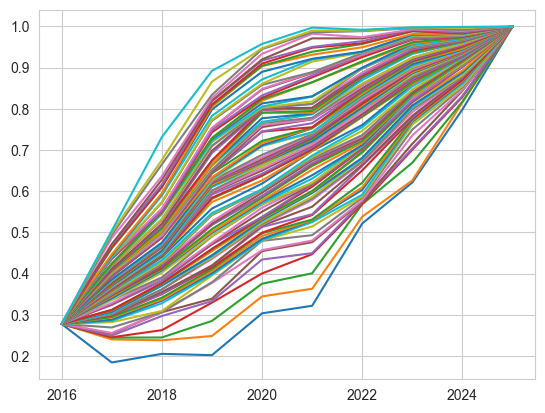

In [447]:
gp_truncated_df.plot(legend=False)

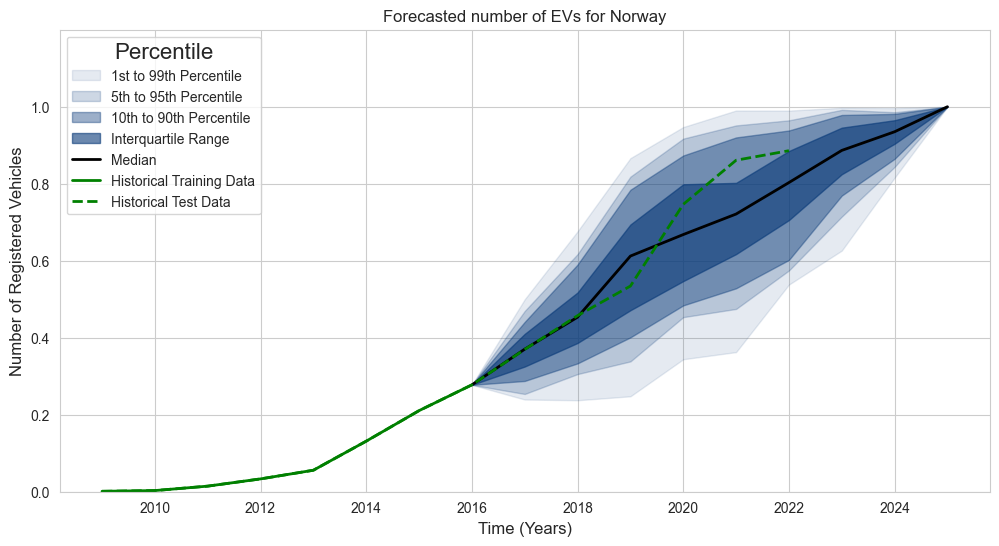

In [456]:
plot_probabilistic_vehicle_forecasts(gp_truncated_df, df['EV_Market_Share_New_Registrations'], 'EV')

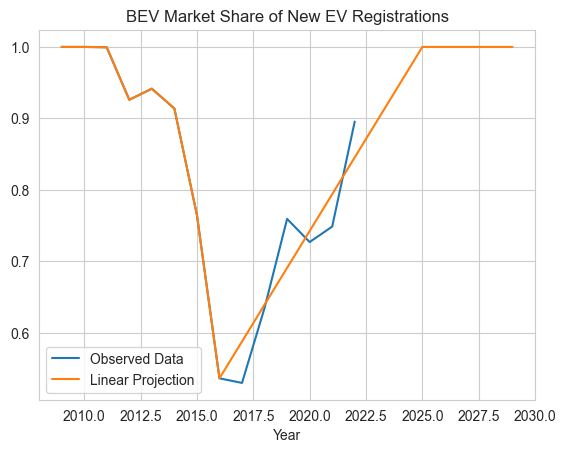

In [100]:
fig, ax = plt.subplots()
df['BEV_Market_Share_New_EV_Registrations'].plot(ax=ax, label='Observed Data')
bev_sales_share.plot(ax=ax, label='Linear Projection')
plt.legend()
plt.title('BEV Market Share of New EV Registrations')
plt.show()

## Need to capture this trend!

<Axes: xlabel='Year'>

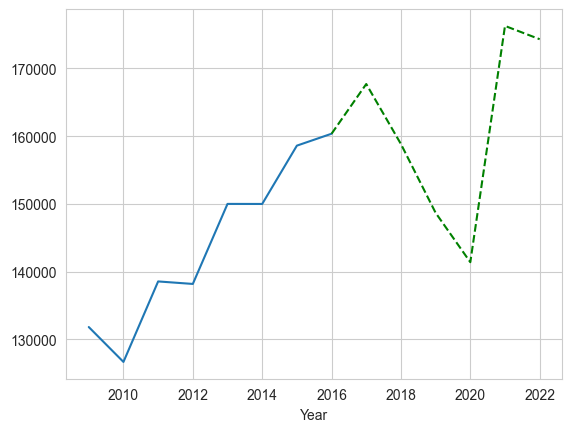

In [521]:
fig, ax = plt.subplots()
df.loc[:t_max, 'Total_New_Registrations'].plot(ax=ax, label='Historical Train')
df.loc[t_max:, 'Total_New_Registrations'].plot(ax=ax, color='green', linestyle='--', label='Historical Test')

# ARIMA

In [523]:
df.loc[:t_max, 'Total_New_Registrations']

Year
2009    131818.0
2010    126667.0
2011    138552.0
2012    138182.0
2013    150000.0
2014    149992.0
2015    158603.0
2016    160363.0
Name: Total_New_Registrations, dtype: float64

In [530]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [538]:
from datetime import datetime

In [541]:
datetime(year=2000, month=1, day=1)

datetime.datetime(2000, 1, 1, 0, 0)

In [ ]:
pd.to_datetime

In [545]:
df.loc[:t_max, 'Year_Datetime'].values

array(['2009-01-01T00:00:00.000000000', '2010-01-01T00:00:00.000000000',
       '2011-01-01T00:00:00.000000000', '2012-01-01T00:00:00.000000000',
       '2013-01-01T00:00:00.000000000', '2014-01-01T00:00:00.000000000',
       '2015-01-01T00:00:00.000000000', '2016-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [999]:
# Fit ARIMA model
model = ARIMA(endog = df.loc[:t_max, 'Total_New_Registrations'].values, dates=df.loc[:t_max, 'Year_Datetime'].values, order=(2, 1, 2))  # Example order, you can tune these values
model_fit = model.fit()

/Users/isaacflower/miniconda3/envs/probabilistic_ev_demand_modelling/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/isaacflower/miniconda3/envs/probabilistic_ev_demand_modelling/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


In [740]:
# Forecast
forecast_steps = horizon-t_max  # Number of years to forecast

In [1000]:
# Get forecast and associated confidence intervals
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_std = np.sqrt(forecast.var_pred_mean)  # Standard deviations from the forecast

In [1001]:
forecast_mean

array([167372.92194603, 169595.42665096, 175568.32820128, 178232.99736502,
       183435.11207341, 186343.22198297, 190959.96428044, 193978.54327123,
       198139.83641872, 201180.76652518, 204978.39025264, 207984.10874467,
       211483.58323971, 214417.30192081])

In [1002]:
forecast_std

array([ 6211.46596792,  8644.86837459, 10845.9517759 , 12625.67569248,
       14377.32972481, 15931.7644681 , 17479.70738048, 18914.05084976,
       20343.40775578, 21700.55776454, 23051.28658158, 24353.05390535,
       25647.01382126, 26906.02573285])

In [1003]:
forecast_mean = np.insert(forecast_mean, obj=0, values=df.loc[t_max, 'Total_New_Registrations'])
forecast_std = np.insert(forecast_std, obj=0, values=0)

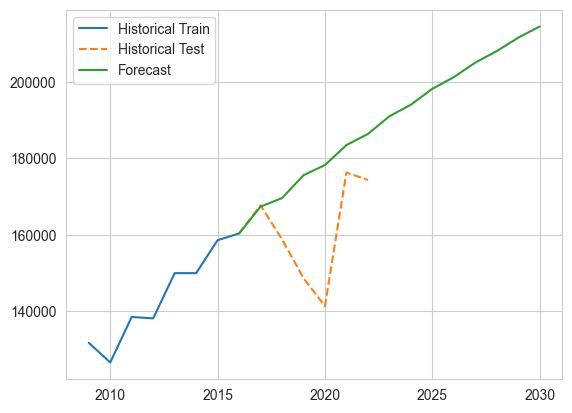

In [1004]:
fig, ax = plt.subplots()
ax.plot(np.arange(2009, t_max+1), df.loc[:t_max, 'Total_New_Registrations'].values, label='Historical Train')
ax.plot(np.arange(t_max, 2023), df.loc[t_max:, 'Total_New_Registrations'].values, linestyle='--', label='Historical Test')
ax.plot(np.arange(t_max, horizon+1), forecast_mean, label='Forecast')
plt.legend()

In [1005]:
forecast_std

array([    0.        ,  6211.46596792,  8644.86837459, 10845.9517759 ,
       12625.67569248, 14377.32972481, 15931.7644681 , 17479.70738048,
       18914.05084976, 20343.40775578, 21700.55776454, 23051.28658158,
       24353.05390535, 25647.01382126, 26906.02573285])

In [1006]:
# Get forecast and associated confidence intervals
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_std = np.sqrt(forecast.var_pred_mean)  # Standard deviations from the forecast

forecast_mean = np.insert(forecast_mean, obj=0, values=df.loc[t_max, 'Total_New_Registrations'])
forecast_std = np.insert(forecast_std, obj=0, values=0)

# Number of samples for each forecasted year
n_sim = 1000

# Sample possible values for each forecasted year
new_vehicles_samples = []

for mean, std in zip(forecast_mean, forecast_std):
    # Sample random errors from a normal distribution based on forecast std
    random_errors = np.random.normal(loc=0, scale=std, size=n_sim)
    
    # Generate sampled values by adding random errors to the forecasted mean
    sampled_year_values = mean + random_errors
    
    # Append sampled values to the list
    new_vehicles_samples.append(sampled_year_values)

# Convert sampled values list to a numpy array
new_vehicles_samples = np.array(new_vehicles_samples)

new_vehicles_samples_df = pd.DataFrame(index=np.arange(t_max, horizon+1), columns=range(0, n_sim), data=new_vehicles_samples)

new_vehicles_samples_df

0              1              2              3    \
2016  160363.000000  160363.000000  160363.000000  160363.000000   
2017  161899.367812  173895.118091  154823.075948  166288.667165   
2018  163419.011941  178082.414425  163241.029943  145944.003740   
2019  171687.254756  176653.839295  171283.253824  174689.358355   
2020  187148.946649  180896.235614  187662.770534  190474.508175   
2021  175563.612075  179031.591652  194130.723520  184985.691543   
2022  198485.773391  216497.591693  177267.465561  175564.825464   
2023  154015.823736  199363.612247  149027.116461  195153.642432   
2024  176006.903876  182792.627688  195112.147296  170377.865582   
2025  201970.516514  205334.155763  196337.041833  209725.701319   
2026  203830.273513  237237.268674  185762.735672  186673.725921   
2027  228706.758466  237013.815416  179377.445232  232268.321236   
2028  215597.797361  211626.168966  210307.007724  230931.483557   
2029  191868.901637  200009.746780  216961.041870  201969.251249   
2030  211319.794125  199255.453981  186374.068408  242088.535061   

                4              5              6              7    \
2016  160363.000000  160363.000000  160363.000000  160363.000000   
2017  170924.342184  175942.145057  178285.913471  168896.409207   
2018  166559.533781  162001.892358  168222.566958  184519.808294   
2019  163072.360587  178822.100172  163023.020714  177562.497539   
2020  171329.165678  169911.190865  175978.443221  177946.643143   
2021  166818.672731  182366.895955  181520.984773  185173.608135   
2022  183167.466297  188178.100076  200576.474843  156509.811727   
2023  159062.771026  144380.754760  169082.201443  188361.904001   
2024  221266.194284  174044.262427  187755.720767  211781.868714   
2025  220863.331360  256395.344950  205342.388511  216753.158721   
2026  223802.765401  206261.310440  189242.772681  166920.606929   
2027  189106.789448  203037.394150  165090.469428  215197.047901   
2028  223238.985420  203517.803835  167621.396932  192566.207313   
2029  229419.102195  242579.721492  200764.361234  214004.556189   
2030  258857.845673  214151.336312  239278.598470  220702.254344   

                8              9    ...            990            991  \
2016  160363.000000  160363.000000  ...  160363.000000  160363.000000   
2017  155218.314523  164511.613913  ...  182588.507931  169430.919273   
2018  174667.027143  154458.831046  ...  184511.405386  176217.394794   
2019  196995.930453  201685.791201  ...  175656.598288  161125.825982   
2020  180399.220482  176999.319749  ...  170716.179868  213553.855118   
2021  206530.167387  194151.412794  ...  177264.612073  179628.685272   
2022  162322.224792  180116.368989  ...  170659.366506  172661.130184   
2023  211041.781785  222091.915159  ...  182812.142221  198438.604491   
2024  221108.687682  229818.205742  ...  195052.029417  160650.271284   
2025  209308.585471  214370.589092  ...  212816.424627  212774.540662   
2026  205828.141526  214200.966078  ...  198694.681592  216147.163083   
2027  139803.939364  142592.042049  ...  211155.844262  185229.957967   
2028  162913.693724  211473.431019  ...  184124.842172  211003.147687   
2029  203329.118196  246521.225584  ...  157097.859527  215586.441361   
2030  149831.840312  204476.302196  ...  203854.734555  198207.152212   

                992            993            994            995  \
2016  160363.000000  160363.000000  160363.000000  160363.000000   
2017  174201.513734  166559.120546  172629.510062  162132.043863   
2018  184372.113152  159725.129823  163395.526644  172243.535669   
2019  168416.542616  172825.061799  165394.653876  192232.005345   
2020  182689.760014  179420.449175  180352.077130  188734.649832   
2021  198659.804455  178916.717788  171568.165320  203891.508534   
2022  187962.532856  194300.051034  168768.864280  227789.694576   
2023  182274.670862  172844.695487  164636.633630  181822.663894   
2024  181994.346574  174903.690681  195506.075529  174814

In [870]:
new_vehicles_samples 

array([[160363.        , 160363.        , 160363.        , ...,
        160363.        , 160363.        , 160363.        ],
       [164011.64225644, 164994.72200749, 167428.88587867, ...,
        163730.99441497, 165597.98119278, 161730.07671238],
       [164864.78420897, 167271.45911334, 165828.06358087, ...,
        166573.05911859, 180015.56666016, 165843.73136894],
       ...,
       [153897.3576927 , 171145.19351481, 199160.0522873 , ...,
        182477.65533963, 173522.4958036 , 190865.38705077],
       [182347.27953442, 190198.18969092, 163994.21085103, ...,
        159831.42323138, 163539.08781155, 166957.74668435],
       [152369.1556662 , 178324.38632136, 203060.88575385, ...,
        177276.28080027, 176438.18346826, 197517.62496578]])

<Axes: >

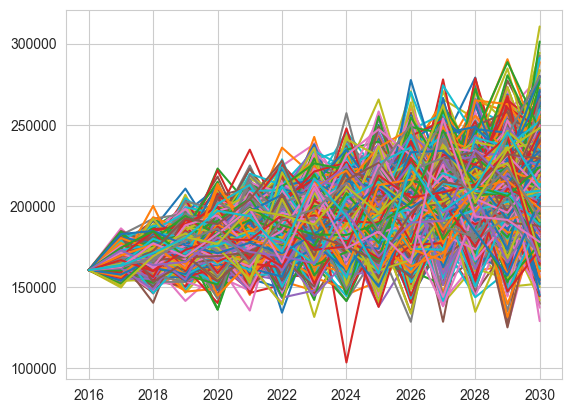

In [1007]:
new_vehicles_samples_df.plot(legend=False)

(2009.0, 2030.0)

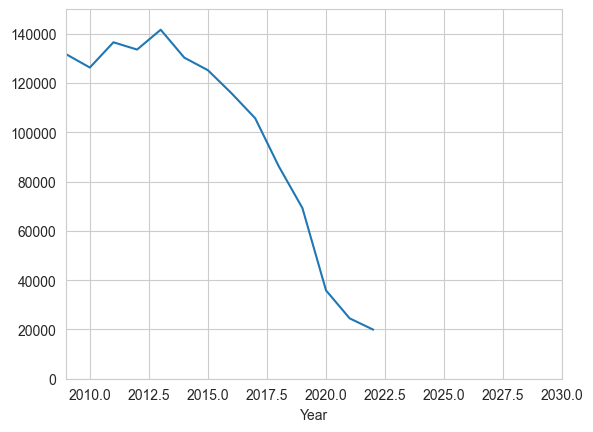

In [146]:
df['ICEV_New_Registrations'].plot()
plt.ylim(0, 150000)
plt.xlim(2009, horizon)

<Axes: xlabel='Year'>

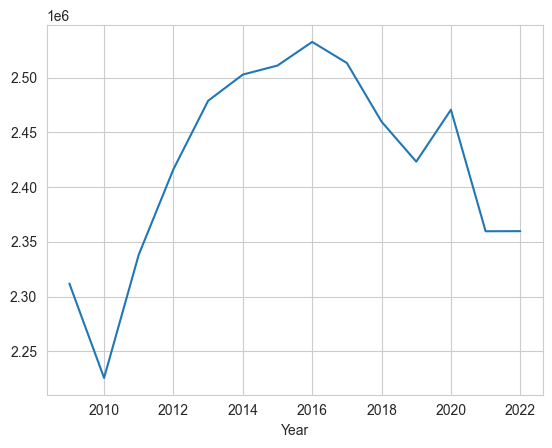

In [149]:
df['ICEV_Stock'].plot()

In [102]:
total_new_registrations = df.loc[:t_max, 'Total_New_Registrations'].to_numpy()

In [103]:
RANDOM_SEED = 42

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

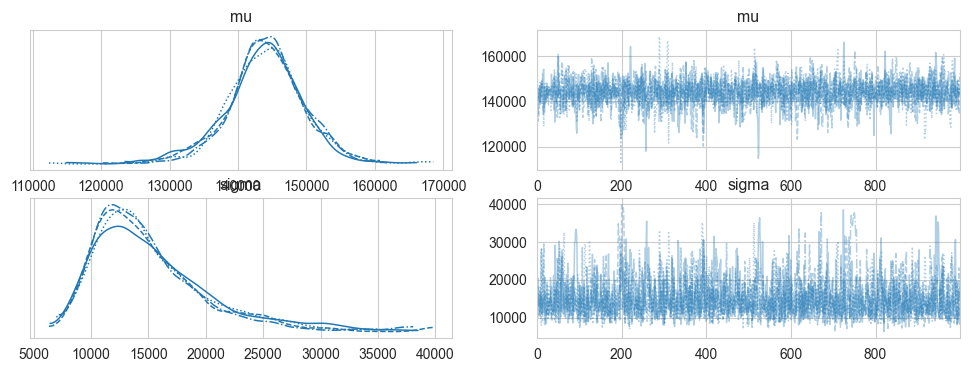

In [104]:
with pm.Model() as new_vehicle_model:
    # Priors for the parameters (need to remove reference to target_lsoa_data)
    mu = pm.Uniform('mu', lower=0, upper=1.5*np.max(total_new_registrations))  # Prior for the mean
    sigma = pm.Uniform('sigma', lower=0, upper=40000)  # Prior for the standard deviation

    # Likelihood (sampling distribution) of the observed data
    counts_observed = pm.TruncatedNormal('counts_observed', mu=mu, sigma=sigma, lower=0, observed=total_new_registrations)

with new_vehicle_model:
    trace = pm.sample(draws=1000, tune=2000, random_seed=RANDOM_SEED, progressbar=True)

az.plot_trace(trace)

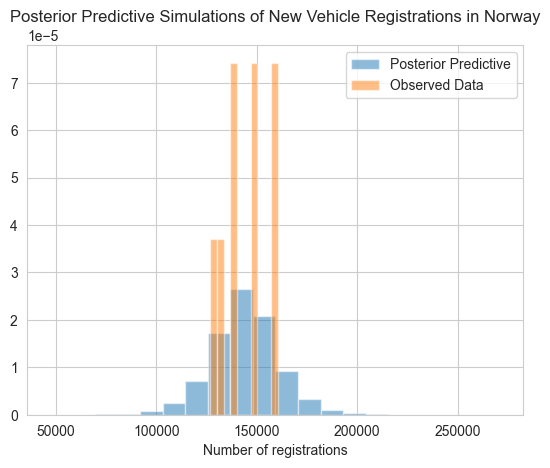

In [868]:
# Generate random samples from the posterior predictive distribution
with new_vehicle_model:
    posterior_predictive = pm.sample_posterior_predictive(trace)

# Plot the posterior predictive distribution
plt.hist(posterior_predictive.posterior_predictive.counts_observed.values.flatten(), bins=20, density=True, alpha=0.5, label='Posterior Predictive')
plt.hist(total_new_registrations, bins=10, density=True, alpha=0.5, label='Observed Data')
plt.xlabel('Number of registrations')
plt.legend()
plt.title('Posterior Predictive Simulations of New Vehicle Registrations in Norway')
plt.show()

In [892]:
# Creates a range of numeric dates between t0 and t1 at a given sample rate
forecast_dates = np.arange(t_max, horizon+1)

n_sim = 1000 # Number of simulated forecasting trajectories
new_vehicles_random = np.random.choice(posterior_predictive.posterior_predictive.counts_observed.values.flatten(), size=(n_sim, len(forecast_dates)))

In [893]:
forecast_dates 

array([2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026,
       2027, 2028, 2029, 2030])

In [894]:
df.loc[t_max, 'EV_New_Registrations']

44530

In [980]:
new_ev_forecast = pd.DataFrame(index=forecast_dates, columns=range(0, n_sim))
new_icev_forecast = pd.DataFrame(index=forecast_dates, columns=range(0, n_sim))
new_bev_forecast = pd.DataFrame(index=forecast_dates, columns=range(0, n_sim))
new_phev_forecast = pd.DataFrame(index=forecast_dates, columns=range(0, n_sim))

# Simulate new registrations
for i in range(0, n_sim):
    new_ev_forecast[i] = ev_sales_share.loc[forecast_dates].multiply(new_vehicles_random[i], axis='rows')
    new_icev_forecast[i] = icev_sales_share.loc[forecast_dates].multiply(new_vehicles_random[i], axis='rows')
    new_bev_forecast[i] = bev_sales_share.loc[forecast_dates].multiply(new_ev_forecast[i], axis='rows')
    new_phev_forecast[i] = phev_sales_share.loc[forecast_dates].multiply(new_ev_forecast[i], axis='rows')

new_ev_forecast.loc[t_max] = np.repeat(df.loc[t_max, 'EV_New_Registrations'], n_sim)
new_ev_forecast = new_ev_forecast.sort_index()

new_icev_forecast.loc[t_max] = np.repeat(df.loc[t_max, 'ICEV_New_Registrations'], n_sim)
new_icev_forecast = new_icev_forecast.sort_index()

new_bev_forecast.loc[t_max] = np.repeat(df.loc[t_max, 'BEV_New_Registrations'], n_sim)
new_bev_forecast = new_bev_forecast.sort_index()

new_phev_forecast.loc[t_max] = np.repeat(df.loc[t_max, 'PHEV_New_Registrations'], n_sim)
new_phev_forecast = new_phev_forecast.sort_index()

In [981]:
new_ev_forecast

0              1              2              3    \
2016   44530.000000   44530.000000   44530.000000   44530.000000   
2017   50110.772959   53599.475186   48931.586598   54464.901908   
2018   50412.680101   64769.694311   59234.637404   64710.586795   
2019   86247.775093   77189.410866   66375.983147   72669.716428   
2020   90342.915129   87937.564252   83128.199986  100331.089046   
2021   91416.719879   87563.224388   94540.081162   75319.778626   
2022  118407.645008   97501.963146  105847.491156  103948.115109   
2023  118380.843098  104317.659698  126080.102312  145363.320137   
2024  196038.365634  112057.592411  174931.979503  161009.662190   
2025  118491.815465  124415.251073  153496.245144  141820.310425   
2026  148392.725262  130462.457134  155303.950612  124561.901464   
2027  133179.432722  154989.668800  146025.015703   98415.639272   
2028  132343.997588  148252.940862  140170.880768  142855.931881   
2029  121668.297925  114343.147793  136768.147527  117472.984585   
2030  132618.466709  146393.664863  149451.967620  151137.595219   

                4              5              6              7    \
2016   44530.000000   44530.000000   44530.000000   44530.000000   
2017   69201.774260   57764.941303   58992.820855   44061.401359   
2018   62602.539864   64899.909421   71785.594010   58008.210996   
2019   68595.148905   80964.180138   78875.666726   79136.008556   
2020   70150.733137   84906.594164   99447.632495   70417.680789   
2021   87757.373170   94522.798718  118100.316345   98751.406209   
2022  113711.837210  104378.953033   92174.115714  107986.302763   
2023  122224.205775  117542.156246  116678.073767  113807.022922   
2024  138107.377283  133854.789777  143493.626560  127482.179174   
2025  138920.432412  133316.492502  126768.458381  139145.280627   
2026  110314.726483  152356.074680  142184.258825  152635.241216   
2027  150654.131475  136089.430559  120688.741882  166902.121310   
2028  129427.180677  154979.524773  170606.725105  134853.527813   
2029  149451.561727  155718.528237  158590.756621  131876.777931   
2030  124351.037368  146378.832929  149994.248233  161685.669898   

                8              9    ...            990            991  \
2016   44530.000000   44530.000000  ...   44530.000000   44530.000000   
2017   40103.130202   43784.585364  ...   48288.117886   54623.064990   
2018   74892.388782   45839.938741  ...   65499.911684   64739.876063   
2019   69433.084728   86284.034893  ...   71223.954864   76394.857316   
2020  129037.643169   88909.295382  ...   85373.990302   77324.778529   
2021  102018.875701  102670.303651  ...   88293.486941  107884.263305   
2022  112059.249933   93771.985918  ...  121830.723234  110222.892058   
2023  148044.988254  145780.482669  ...  119792.841081  109686.801378   
2024  121324.124612  170253.925040  ...  118335.368195  127682.605067   
2025  123987.453357  178166.187291  ...  119140.506244  148893.671935   
2026  145313.587453  129335.692374  ...  140555.300354  138048.241019   
2027  130488.309073  187586.733532  ...  104600.041500  137046.288626   
2028  143159.035112  148984.035222  ...  149418.333992  129917.204890   
2029  140372.309339  152904.990437  ...  144011.661934  158773.848926   
2030  145006.568330  129046.314526  ...  119803.993648  155034.287862   

                992            993            994            995  \
2016   44530.000000   44530.000000   44530.000000   44530.000000   
2017   57168.754187   44692.193023   41424.457066   53528.344680   
2018   63062.360483   63607.928877   66440.653414   58663.223862   
2019   70599.027615   85477.034052   81815.604297   76962.930576   
2020  107328.233504   91645.559983   91976.684389   82152.089290   
2021   83025.029539  103610.987682   99806.046019  102732.141436   
2022  108452.118386  127487.856099  119320.330064   88487.024122   
2023  118836.382423  121537.003778   87199.523292  128413.976289   
2024  124286.027106  136013.028649  121173.335390  138379

<Axes: title={'center': 'Simulated New ICEV Registrations for Norway'}>

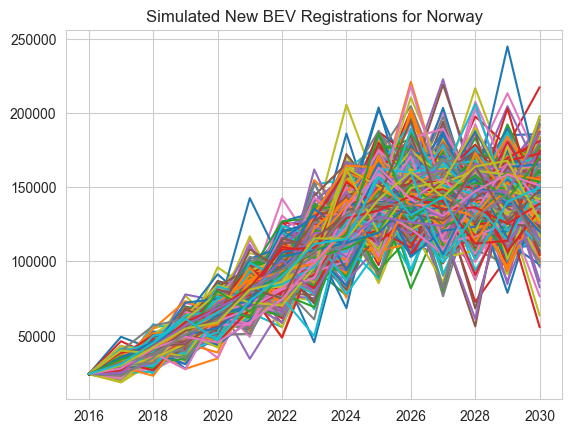

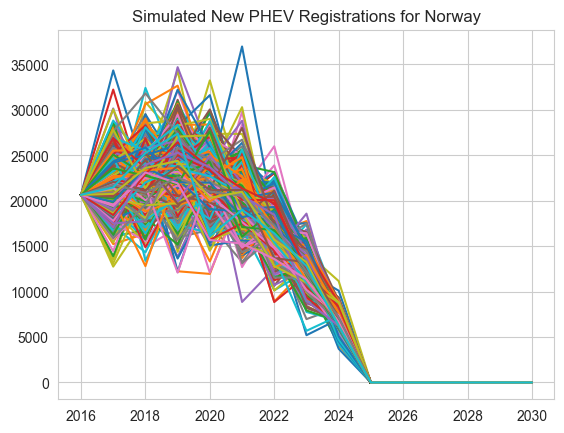

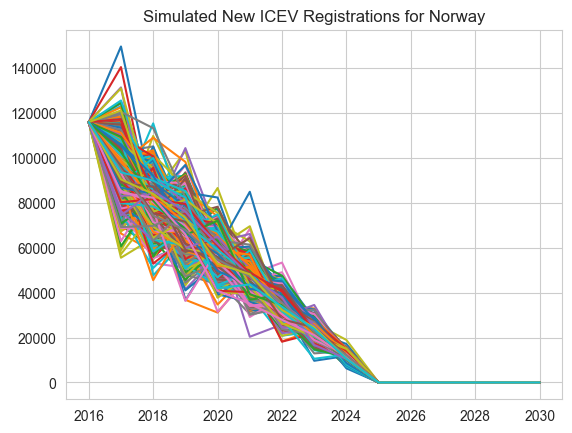

In [982]:
new_bev_forecast.plot(title='Simulated New BEV Registrations for Norway', legend=False)
new_phev_forecast.plot(title='Simulated New PHEV Registrations for Norway', legend=False)
new_icev_forecast.plot(title='Simulated New ICEV Registrations for Norway', legend=False)

# Using ARIMA instead of Bayesian Stats

In [1008]:
new_ev_forecast = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1))
new_icev_forecast = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1))
new_bev_forecast = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1))
new_phev_forecast = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1))

# Simulate new registrations
for i in range(0, n_sim):
    new_ev_forecast[i+1] = ev_sales_share.loc[forecast_dates].multiply(new_vehicles_samples_df[i], axis='rows')
    new_icev_forecast[i+1] = icev_sales_share.loc[forecast_dates].multiply(new_vehicles_samples_df[i], axis='rows')
    new_bev_forecast[i+1] = bev_sales_share.loc[forecast_dates].multiply(new_ev_forecast[i+1], axis='rows')
    new_phev_forecast[i+1] = phev_sales_share.loc[forecast_dates].multiply(new_ev_forecast[i+1], axis='rows')

<Axes: title={'center': 'Simulated New ICEV Registrations for Norway'}>

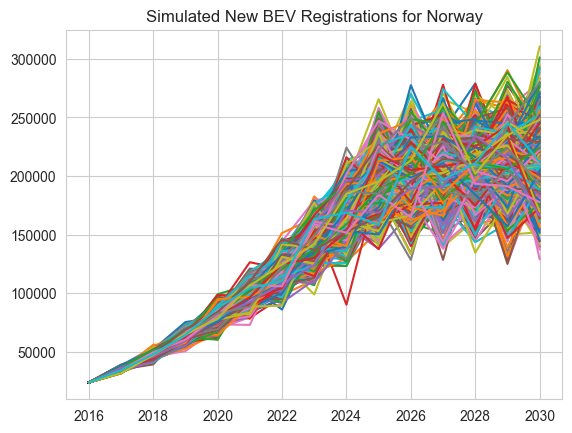

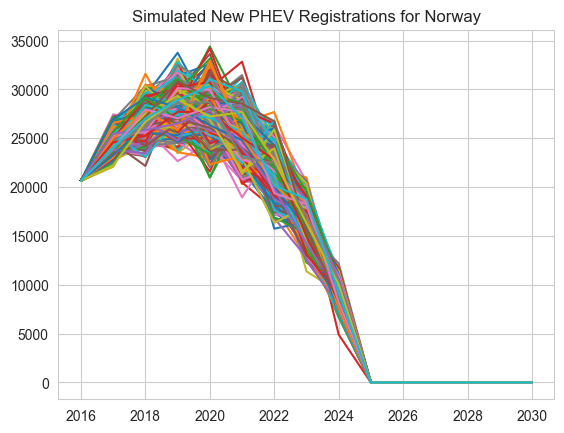

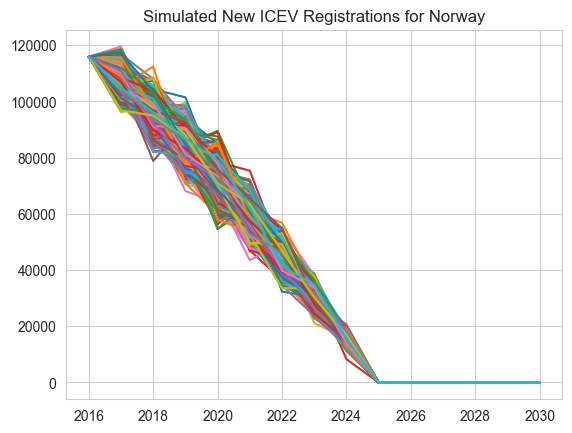

In [1009]:
new_bev_forecast.plot(title='Simulated New BEV Registrations for Norway', legend=False)
new_phev_forecast.plot(title='Simulated New PHEV Registrations for Norway', legend=False)
new_icev_forecast.plot(title='Simulated New ICEV Registrations for Norway', legend=False)

Sampling: [mu, sigma, vehicle_lifetime]


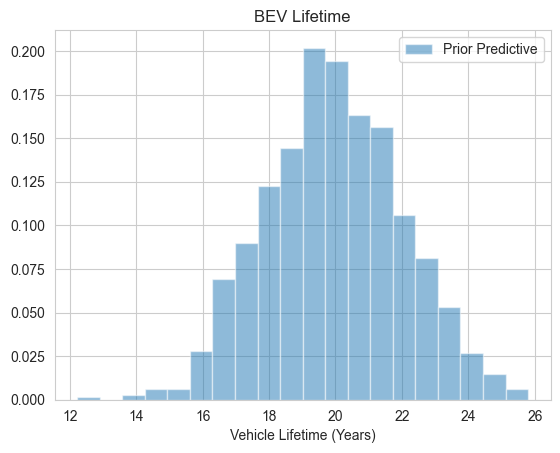

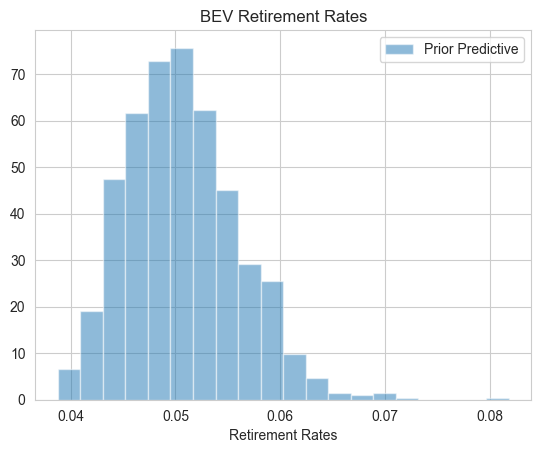

In [1025]:
with pm.Model() as retired_bev_model:
    # Priors for the parameters (need to remove reference to target_lsoa_data)
    mu = pm.Normal('mu', mu=bev_lifetime, sigma=2)  # Prior for the mean
    sigma = pm.Exponential('sigma', lam=2)  # Prior for the standard deviation

    # Likelihood (sampling distribution) of the observed data
    vehicle_lifetime = pm.TruncatedNormal('vehicle_lifetime', mu=mu, sigma=sigma, lower=0)
    retirement_rate = pm.Deterministic('retirement_rate', 1/(vehicle_lifetime))

with retired_bev_model:
    retired_bev_prior_predictive = pm.sample_prior_predictive(samples=1000, random_seed=RANDOM_SEED)

# Plot the prior predictive distribution for vehicle lifetime
plt.hist(
    retired_bev_prior_predictive.prior.vehicle_lifetime.values.flatten(), 
    bins=20, 
    density=True, 
    alpha=0.5, 
    label='Prior Predictive'
)
# plt.xlim(0, 0.5)
plt.xlabel('Vehicle Lifetime (Years)')
plt.legend()
plt.title('BEV Lifetime')
plt.show()

# Plot the prior predictive distribution for retirement rate
plt.hist(
    retired_bev_prior_predictive.prior.retirement_rate.values.flatten(), 
    bins=20, 
    density=True, 
    alpha=0.5, 
    label='Prior Predictive'
)
# plt.xlim(0, 0.5)
plt.xlabel('Retirement Rates')
plt.legend()
plt.title('BEV Retirement Rates')
plt.show()

Sampling: [mu, sigma, vehicle_lifetime]


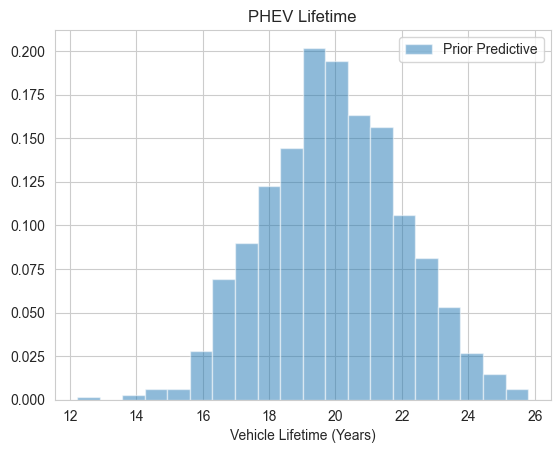

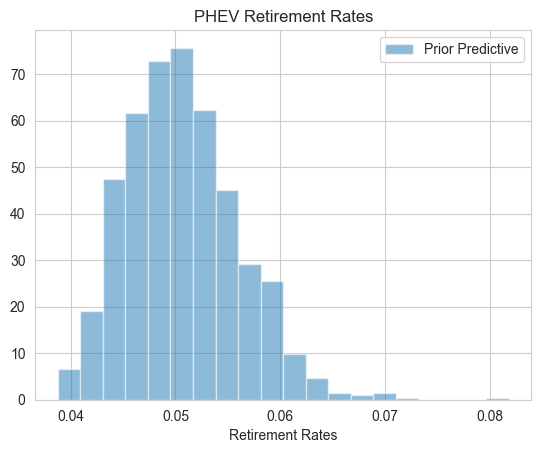

In [1024]:
with pm.Model() as retired_phev_model:
    # Priors for the parameters (need to remove reference to target_lsoa_data)
    mu = pm.Normal('mu', mu=phev_lifetime, sigma=2)  # Prior for the mean
    sigma = pm.Exponential('sigma', lam=2)  # Prior for the standard deviation

    # Likelihood (sampling distribution) of the observed data
    vehicle_lifetime = pm.TruncatedNormal('vehicle_lifetime', mu=mu, sigma=sigma, lower=0)
    retirement_rate = pm.Deterministic('retirement_rate', 1/(vehicle_lifetime))

with retired_phev_model:
    retired_phev_prior_predictive = pm.sample_prior_predictive(samples=1000, random_seed=RANDOM_SEED)

# Plot the prior predictive distribution for vehicle lifetime
plt.hist(
    retired_phev_prior_predictive.prior.vehicle_lifetime.values.flatten(), 
    bins=20, 
    density=True, 
    alpha=0.5, 
    label='Prior Predictive'
)
# plt.xlim(0, 0.5)
plt.xlabel('Vehicle Lifetime (Years)')
plt.legend()
plt.title('PHEV Lifetime')
plt.show()

# Plot the prior predictive distribution for retirement rates
plt.hist(
    retired_phev_prior_predictive.prior.retirement_rate.values.flatten(), 
    bins=20, 
    density=True, 
    alpha=0.5, 
    label='Prior Predictive'
)
# plt.xlim(0, 0.5)
plt.xlabel('Retirement Rates')
plt.legend()
plt.title('PHEV Retirement Rates')
plt.show()

Sampling: [mu, sigma, vehicle_lifetime]


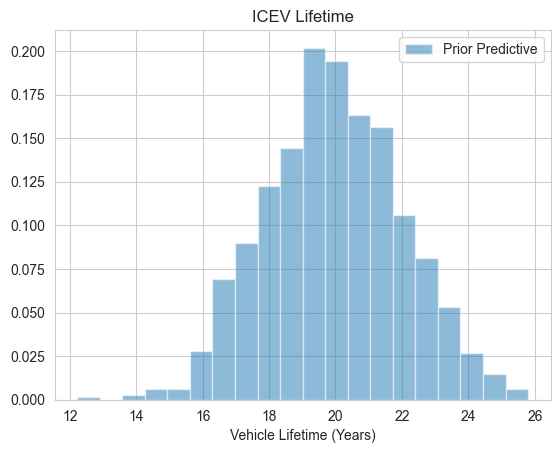

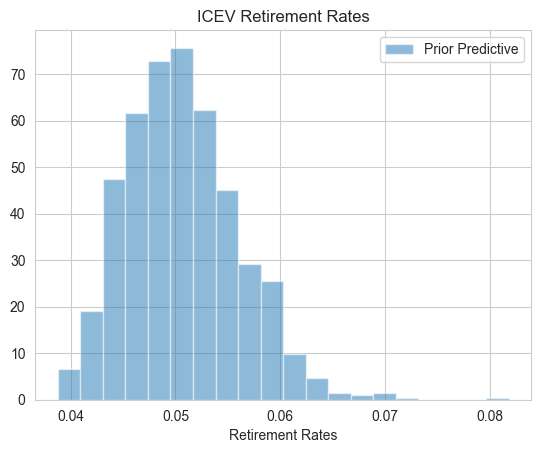

In [1023]:
with pm.Model() as retired_icev_model:
    # Priors for the parameters (need to remove reference to target_lsoa_data)
    mu = pm.Normal('mu', mu=icev_lifetime, sigma=2)  # Prior for the mean
    sigma = pm.Exponential('sigma', lam=2)  # Prior for the standard deviation

    # Likelihood (sampling distribution) of the observed data
    vehicle_lifetime = pm.TruncatedNormal('vehicle_lifetime', mu=mu, sigma=sigma, lower=0)
    retirement_rate = pm.Deterministic('retirement_rate', 1/(vehicle_lifetime))

with retired_icev_model:
    retired_icev_prior_predictive = pm.sample_prior_predictive(samples=1000, random_seed=RANDOM_SEED)

# Plot the prior predictive distribution for vehicle lifetime
plt.hist(
    retired_icev_prior_predictive.prior.vehicle_lifetime.values.flatten(), 
    bins=20, 
    density=True, 
    alpha=0.5, 
    label='Prior Predictive'
)
# plt.xlim(0, 0.5)
plt.xlabel('Vehicle Lifetime (Years)')
plt.legend()
plt.title('ICEV Lifetime')
plt.show()

# Plot the prior predictive distribution for retirement rates
plt.hist(
    retired_icev_prior_predictive.prior.retirement_rate.values.flatten(), 
    bins=20, 
    density=True, 
    alpha=0.5, 
    label='Prior Predictive'
)
# plt.xlim(0, 0.5)
plt.xlabel('Retirement Rates')
plt.legend()
plt.title('ICEV Retirement Rates')
plt.show()

<Axes: title={'center': 'ICEV Forecast'}>

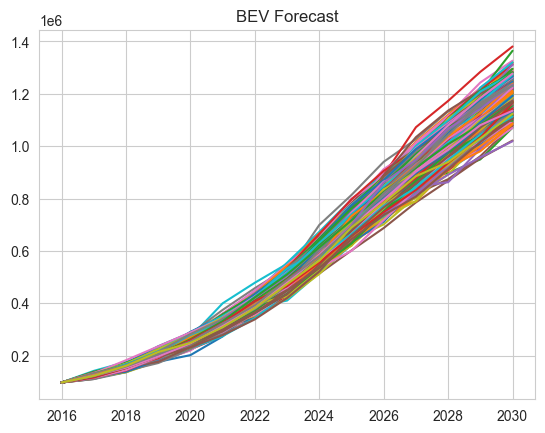

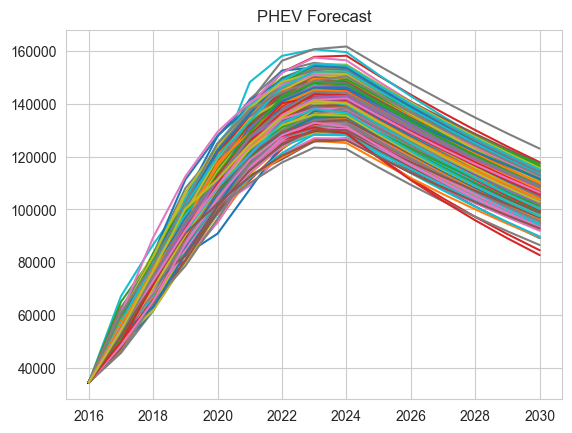

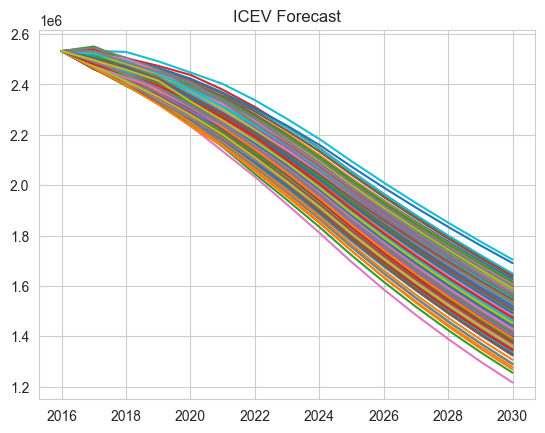

In [983]:
# Create dataframes that contain a column for each simulation and a row for each forecasted date
bev_forecast = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1), dtype=float)
phev_forecast = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1), dtype=float)
icev_forecast = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1), dtype=float)

# Populate forecast with inital starting registrations
bev_forecast.iloc[0] = df['BEV_Stock'].loc[:t_max].iloc[-1]
phev_forecast.iloc[0] = df['PHEV_Stock'].loc[:t_max].iloc[-1]
icev_forecast.iloc[0] = df['ICEV_Stock'].loc[:t_max].iloc[-1]

# Randomly sample retirement rates from posterior/prior predictive distributions
icev_retirement_rates_random = np.random.choice(retired_icev_prior_predictive.prior.retirement_rate.values.flatten(), size=(n_sim))
bev_retirement_rates_random = np.random.choice(retired_bev_prior_predictive.prior.retirement_rate.values.flatten(), size=(n_sim))
phev_retirement_rates_random = np.random.choice(retired_phev_prior_predictive.prior.retirement_rate.values.flatten(), size=(n_sim))

# Making the forecasts by adding new registrations and removing retired vehicles
for i in range(1, len(forecast_dates)):
    bev_forecast.loc[forecast_dates[i]] = bev_forecast.loc[forecast_dates[i-1]] + new_bev_forecast.loc[forecast_dates[i]] - (bev_retirement_rates_random * bev_forecast.loc[forecast_dates[i-1]])
    phev_forecast.loc[forecast_dates[i]] = phev_forecast.loc[forecast_dates[i-1]] + new_phev_forecast.loc[forecast_dates[i]] - (phev_retirement_rates_random * phev_forecast.loc[forecast_dates[i-1]])
    icev_forecast.loc[forecast_dates[i]] = icev_forecast.loc[forecast_dates[i-1]] + new_icev_forecast.loc[forecast_dates[i]] - (icev_retirement_rates_random * icev_forecast.loc[forecast_dates[i-1]])

bev_forecast = round(bev_forecast)
phev_forecast= round(phev_forecast)
icev_forecast = round(icev_forecast)

bev_forecast.plot(legend=False, title='BEV Forecast')
phev_forecast.plot(legend=False, title='PHEV Forecast')
icev_forecast.plot(legend=False, title='ICEV Forecast')

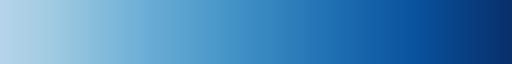

In [450]:
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.colormaps['Blues']
new_cmap = truncate_colormap(cmap, 0.3, 1)
new_cmap

In [451]:
NUM_COLORS = 20
cm = plt.get_cmap('Paired')
colors = [new_cmap(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

In [448]:
def plot_probabilistic_vehicle_forecasts(df, historical_df, vehicle_type):
    
    fig, ax = plt.subplots(figsize=(12,6))

    ax.fill_between(
        x=df.index.values, 
        y1=df.quantile(0.01, axis=1).values, 
        y2=df.quantile(0.99, axis=1).values, 
        color=colors[19],
        alpha=0.1,
        label='1st to 99th Percentile'
    )

    ax.fill_between(
        x=df.index.values, 
        y1=df.quantile(0.05, axis=1).values, 
        y2=df.quantile(0.95, axis=1).values, 
        color=colors[19],
        alpha=0.2,
        label='5th to 95th Percentile'
    )

    ax.fill_between(
        x=df.index.values, 
        y1=df.quantile(0.1, axis=1).values, 
        y2=df.quantile(0.9, axis=1).values, 
        color=colors[19],
        alpha=0.4,
        label='10th to 90th Percentile'
    )

    ax.fill_between(
        x=df.index.values, 
        y1=df.quantile(0.25, axis=1).values, 
        y2=df.quantile(0.75, axis=1).values, 
        color=colors[19],
        alpha=0.6,
        label='Interquartile Range'
    )

    ax.plot(
        df.index.values, 
        df.quantile(0.5, axis=1).values, 
        linewidth=2, 
        c='black', 
        label='Median'
    )

    ax.plot(
        np.arange(historical_df.index[0], t_max+1),
        historical_df.loc[:t_max].values,
        linewidth=2,
        c='green',
        label='Historical Training Data'
    )

    ax.plot(
        historical_df.index,
        historical_df.values,
        linewidth=2,
        c='green',
        label='Historical Test Data',
        linestyle='--'
    )

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles, 
        labels, 
        # bbox_to_anchor=(1, 0.9), 
        title='Percentile', 
        title_fontsize=16, 
        fontsize=10
    )
    ax.set_title('Forecasted number of {}s for Norway'.format(vehicle_type))
    ax.set_ylabel('Number of Registered Vehicles', fontsize=12)
    ax.set_xlabel('Time (Years)', fontsize=12)
    ax.set_ylim(0, 1.2*df.max().max())
    plt.show()

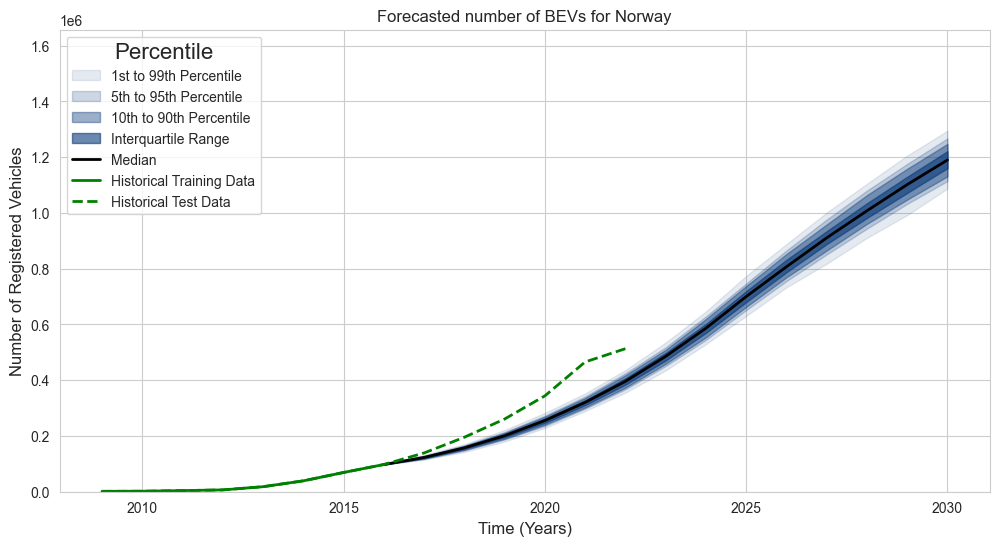

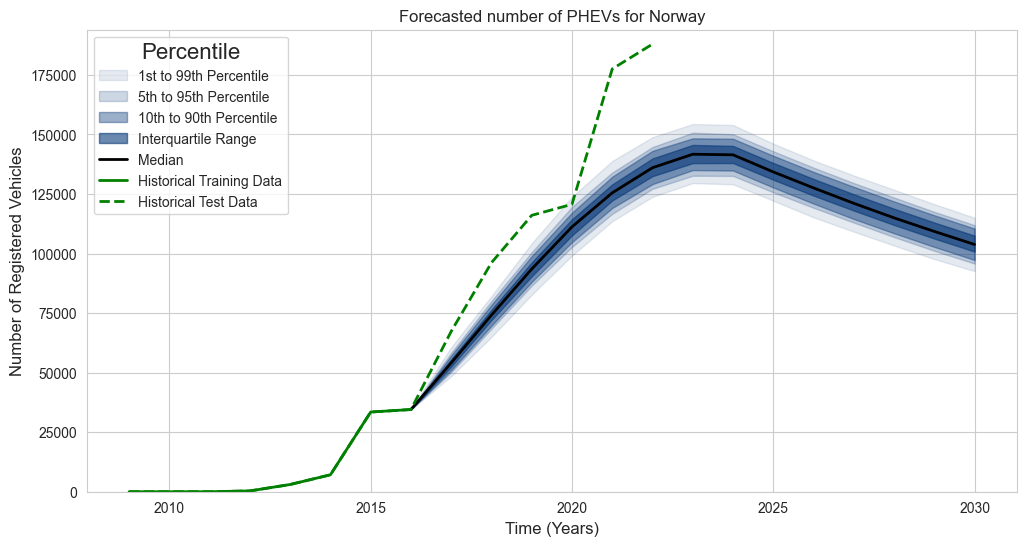

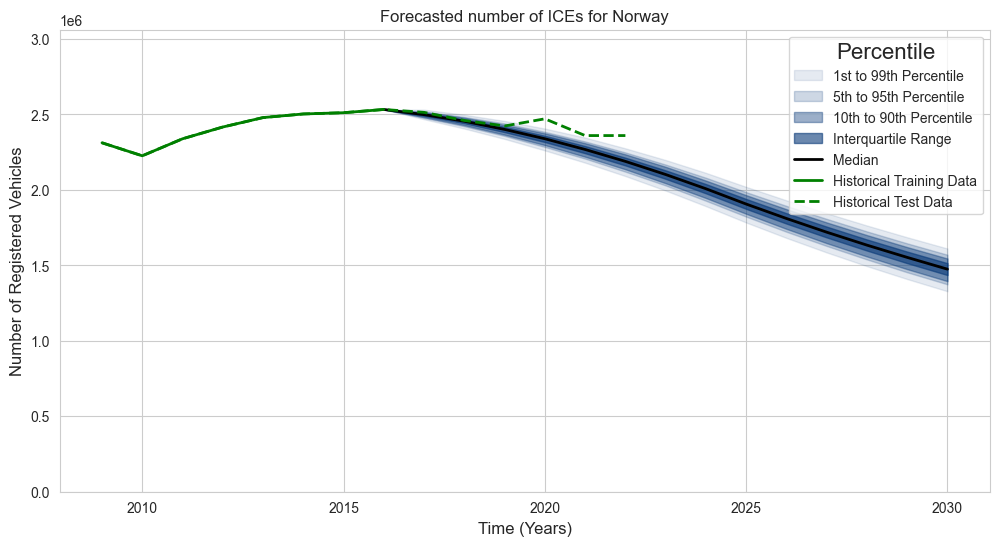

In [984]:
plot_probabilistic_vehicle_forecasts(bev_forecast, df['BEV_Stock'], 'BEV')
plot_probabilistic_vehicle_forecasts(phev_forecast, df['PHEV_Stock'], 'PHEV')
plot_probabilistic_vehicle_forecasts(icev_forecast, df['ICEV_Stock'], 'ICE')

# Incorporating GP Regression into Sales Share Projection

In [460]:
ev_share_gp = train_gp(ev_sales_share)
bev_share_gp = train_gp(bev_sales_share)

/Users/isaacflower/miniconda3/envs/probabilistic_ev_demand_modelling/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [461]:
n_samples = 1000

In [467]:
def truncate_and_sample_gp(gaussian_process, n_samples):

    X = np.arange(t_max, icev_ban + 1).reshape(-1,1)
    
    mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)
    
    a = - mean_prediction/std_prediction # Lower Limit for Projections
    b = (1 - mean_prediction)/std_prediction # Upper Limit for Projections

    gp_truncated = np.zeros([len(X), n_samples])
    
    for i in range(0, len(X)):
        gp_truncated[i] = mean_prediction[i] + std_prediction[i]*np.sort(stats.truncnorm.ppf(np.random.rand(n_samples), a[i], b[i]))
    
    gp_truncated_df = pd.DataFrame(index=np.arange(t_max, icev_ban + 1), columns=range(0, n_samples), data=gp_truncated)
    
    return gp_truncated_df

In [512]:
ev_share_gp_samples = truncate_and_sample_gp(ev_share_gp, n_samples)
bev_share_gp_samples = truncate_and_sample_gp(bev_share_gp, n_samples)

In [505]:
def extend_flatline(df, ban, init):
    date_range = np.arange(df.index.values[0], horizon+1) # Current and Future Dates
    df = df.reindex(date_range)

    # Linear Interpolation
    df.loc[t_max] = init
    df.loc[ban] = 1
    df = df.interpolate()
    return df

In [514]:
ev_share_gp_samples = extend_flatline(ev_share_gp_samples, icev_ban, df.loc[t_max, 'EV_Market_Share_New_Registrations'])
bev_share_gp_samples = extend_flatline(bev_share_gp_samples, icev_ban, df.loc[t_max, 'BEV_Market_Share_New_EV_Registrations'])

icev_share_gp_samples = 1 - ev_share_gp_samples
phev_share_gp_samples = 1 - bev_share_gp_samples

<Axes: title={'center': 'PHEV Share GP Regression Samples'}>

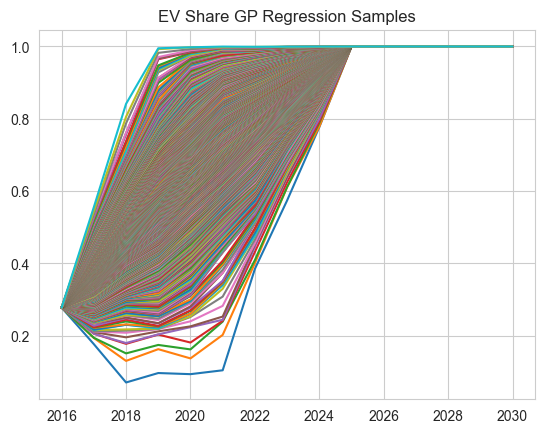

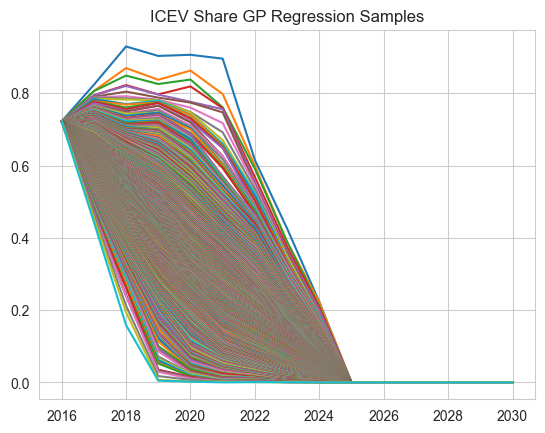

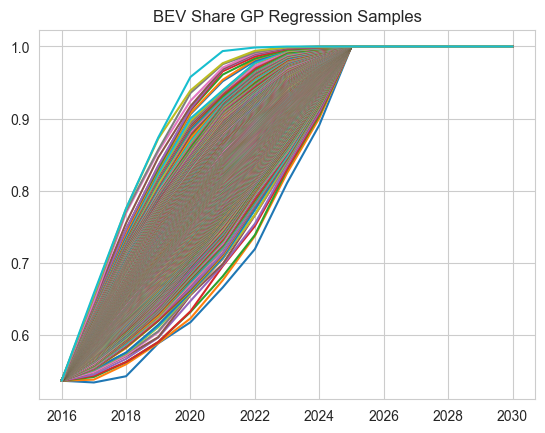

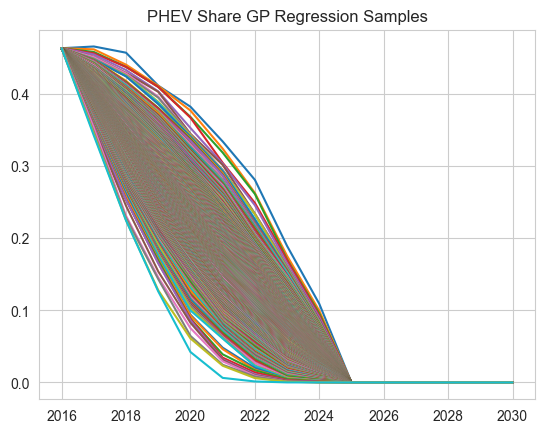

In [865]:
ev_share_gp_samples.plot(legend=False, title='EV Share GP Regression Samples')
icev_share_gp_samples.plot(legend=False, title='ICEV Share GP Regression Samples')
bev_share_gp_samples.plot(legend=False, title='BEV Share GP Regression Samples')
phev_share_gp_samples.plot(legend=False, title='PHEV Share GP Regression Samples')

In [986]:
new_ev_forecast = pd.DataFrame(index=forecast_dates, columns=range(0, n_sim))
new_icev_forecast = pd.DataFrame(index=forecast_dates, columns=range(0, n_sim))
new_bev_forecast = pd.DataFrame(index=forecast_dates, columns=range(0, n_sim))
new_phev_forecast = pd.DataFrame(index=forecast_dates, columns=range(0, n_sim))

# Simulate new registrations
for i in range(0, n_sim):
    new_ev_forecast[i] = ev_share_gp_samples[i].loc[forecast_dates].multiply(new_vehicles_random[i], axis='rows')
    new_icev_forecast[i] = icev_share_gp_samples[i].loc[forecast_dates].multiply(new_vehicles_random[i], axis='rows')
    new_bev_forecast[i] = bev_share_gp_samples[i].loc[forecast_dates].multiply(new_ev_forecast[i], axis='rows')
    new_phev_forecast[i] = phev_share_gp_samples[i].loc[forecast_dates].multiply(new_ev_forecast[i], axis='rows')

new_ev_forecast.loc[t_max] = np.repeat(df.loc[t_max, 'EV_New_Registrations'], n_sim)
new_ev_forecast = new_ev_forecast.sort_index()

new_icev_forecast.loc[t_max] = np.repeat(df.loc[t_max, 'ICEV_New_Registrations'], n_sim)
new_icev_forecast = new_icev_forecast.sort_index()

new_bev_forecast.loc[t_max] = np.repeat(df.loc[t_max, 'BEV_New_Registrations'], n_sim)
new_bev_forecast = new_bev_forecast.sort_index()

new_phev_forecast.loc[t_max] = np.repeat(df.loc[t_max, 'PHEV_New_Registrations'], n_sim)
new_phev_forecast = new_phev_forecast.sort_index()

In [987]:
new_ev_forecast

0              1              2              3    \
2016   44530.000000   44530.000000   44530.000000   44530.000000   
2017   24713.069700   29000.809907   26530.267071   31253.449742   
2018    8104.370612   19240.378337   20400.754289   26189.270734   
2019   16065.916597   24206.546654   22316.025130   28450.285860   
2020   14101.802240   20125.875061   22485.055154   30319.568929   
2021   14023.292441   26054.220733   33254.414516   26753.767424   
2022   59994.792814   51439.313155   57018.452903   59088.759677   
2023   80937.301456   75918.426404   91771.799294  108184.735214   
2024  165613.008817   94776.652411  150007.201477  138793.263697   
2025  118491.815465  124415.251073  153496.245144  141820.310425   
2026  148392.725262  130462.457134  155303.950612  124561.901464   
2027  133179.432722  154989.668800  146025.015703   98415.639272   
2028  132343.997588  148252.940862  140170.880768  142855.931881   
2029  121668.297925  114343.147793  136768.147527  117472.984585   
2030  132618.466709  146393.664863  149451.967620  151137.595219   

                4              5              6              7    \
2016   44530.000000   44530.000000   44530.000000   44530.000000   
2017   39714.818982   33841.452143   34799.446220   26050.735741   
2018   25657.436970   28937.648548   34086.903258   28319.121912   
2019   26932.085110   33091.986939   33175.594670   33362.809546   
2020   26184.891032   32006.863823   39815.925188   29596.552481   
2021   31533.156143   35185.306806   49114.947707   44795.511790   
2022   66751.782696   62190.948100   55293.935476   66240.923944   
2023   92672.806459   89527.149518   90032.019427   88209.839423   
2024  120105.784807  118158.685849  127292.540727  113133.307672   
2025  138920.432412  133316.492502  126768.458381  139145.280627   
2026  110314.726483  152356.074680  142184.258825  152635.241216   
2027  150654.131475  136089.430559  120688.741882  166902.121310   
2028  129427.180677  154979.524773  170606.725105  134853.527813   
2029  149451.561727  155718.528237  158590.756621  131876.777931   
2030  124351.037368  146378.832929  149994.248233  161685.669898   

                8              9    ...            990            991  \
2016   44530.000000   44530.000000  ...   44530.000000   44530.000000   
2017   24139.266953   26379.797799  ...   69389.035964   78810.640001   
2018   37128.970901   24068.463536  ...  108240.036137  106994.557793   
2019   29410.822168   36596.270314  ...  129158.403439  139275.919410   
2020   54609.595535   38618.656958  ...  139960.403384  126852.047588   
2021   49523.130105   51305.893392  ...  129378.920238  158209.626592   
2022   70214.289818   58852.312546  ...  159324.330461  144337.912281   
2023  114992.356523  114682.994243  ...  142461.497982  130455.857109   
2024  107791.449355  151306.580127  ...  128508.462150  138668.925329   
2025  123987.453357  178166.187291  ...  119140.506244  148893.671935   
2026  145313.587453  129335.692374  ...  140555.300354  138048.241019   
2027  130488.309073  187586.733532  ...  104600.041500  137046.288626   
2028  143159.035112  148984.035222  ...  149418.333992  129917.204890   
2029  140372.309339  152904.990437  ...  144011.661934  158773.848926   
2030  145006.568330  129046.314526  ...  119803.993648  155034.287862   

                992            993            994            995  \
2016   44530.000000   44530.000000   44530.000000   44530.000000   
2017   82652.251308   65481.580126   60889.147430   79730.529255   
2018  105747.411863  107133.484285  114788.965080  101763.557674   
2019  129069.613363  159046.895679  152501.290192  143507.196764   
2020  176146.341667  150665.977212  151568.449807  135486.232604   
2021  121834.144667  152075.991203  146519.212509  150884.071646   
2022  142084.243341  167128.540267  156499.731251  116162.197389   
2023  141348.181169  144567.844025  103761.682138  152816.407537   
2024  134988.508757  147735.119776  131637.296442  150333

In [905]:
df.loc[t_max, 'EV_Market_Share_New_Registrations']

0.2776

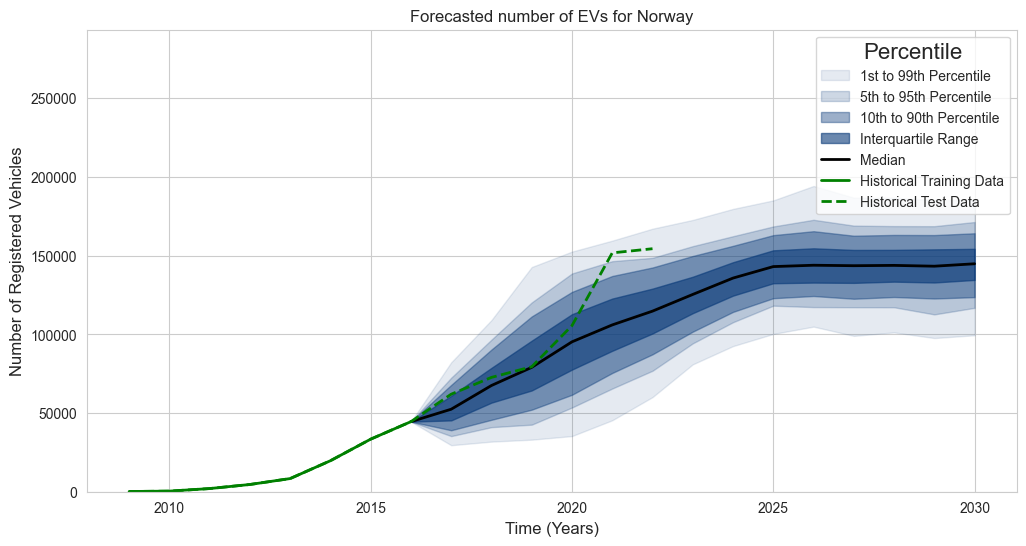

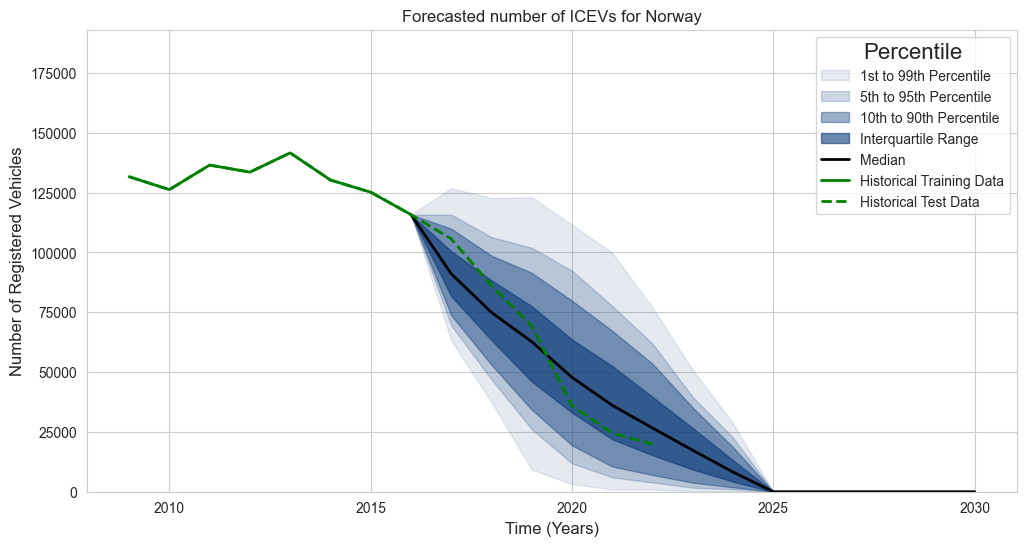

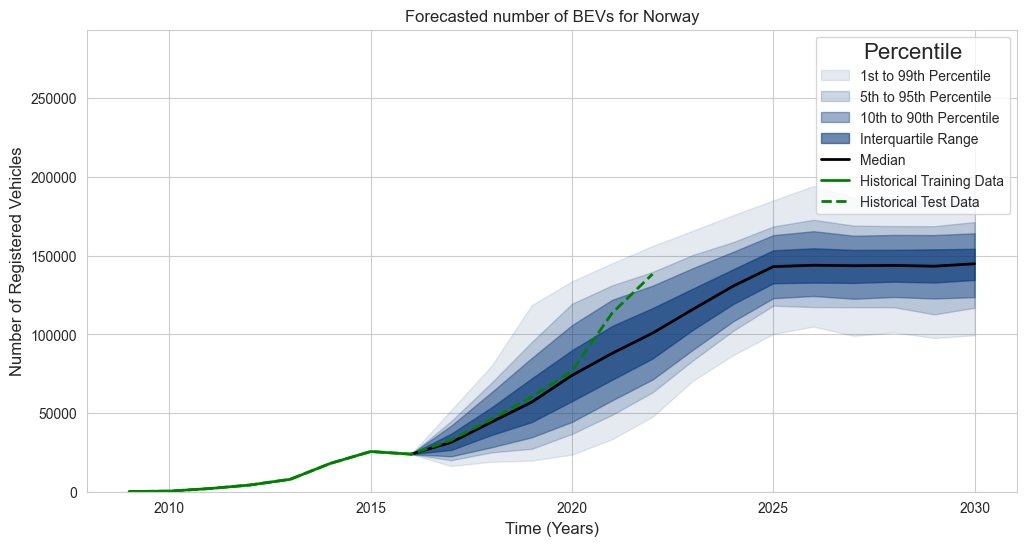

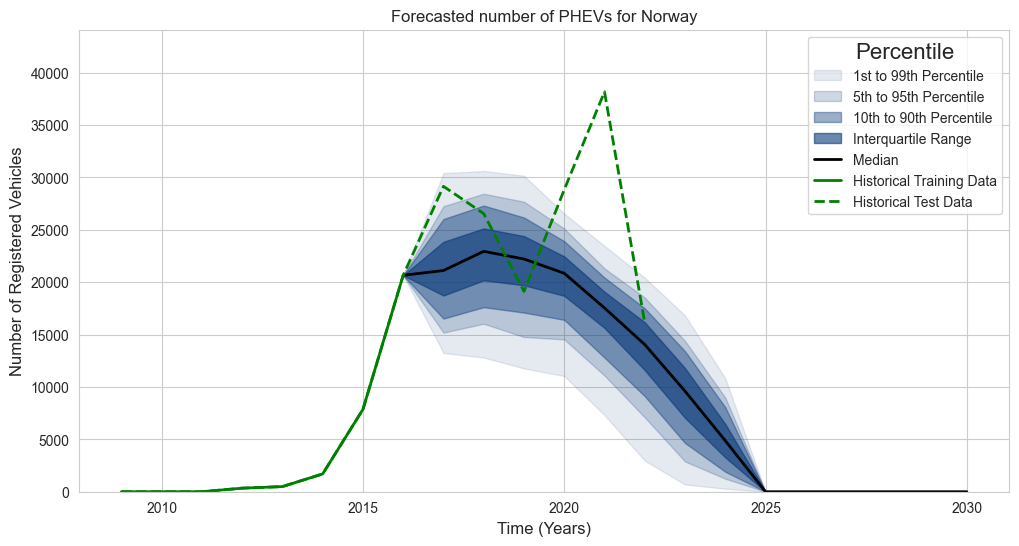

In [988]:
plot_probabilistic_vehicle_forecasts(new_ev_forecast, df['EV_New_Registrations'], 'EV')
plot_probabilistic_vehicle_forecasts(new_icev_forecast, df['ICEV_New_Registrations'], 'ICEV')
plot_probabilistic_vehicle_forecasts(new_bev_forecast, df['BEV_New_Registrations'], 'BEV')
plot_probabilistic_vehicle_forecasts(new_phev_forecast, df['PHEV_New_Registrations'], 'PHEV')

In [908]:
forecast_dates

array([2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026,
       2027, 2028, 2029, 2030])

<Axes: >

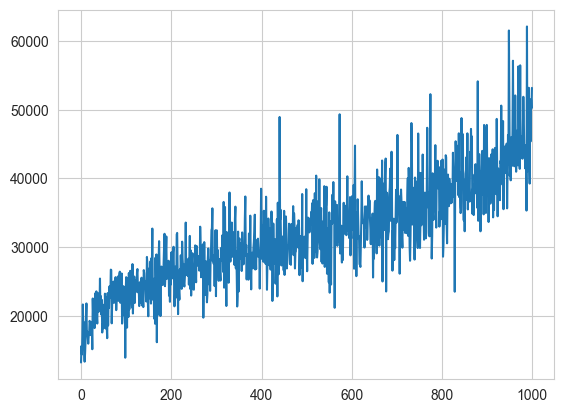

In [977]:
new_bev_forecast.loc[2017].plot()

<Axes: title={'center': 'ICE Forecast'}>

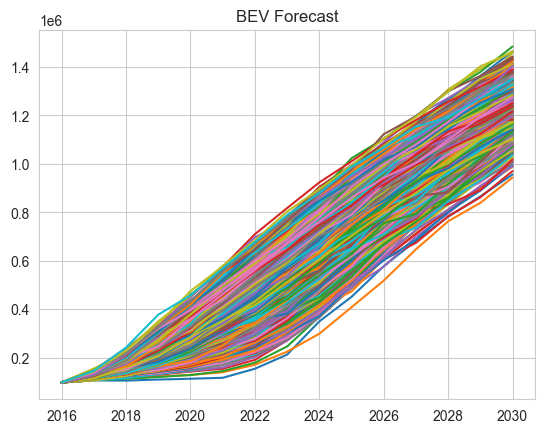

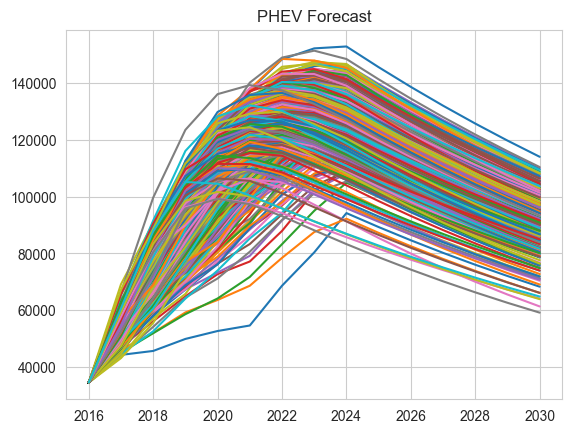

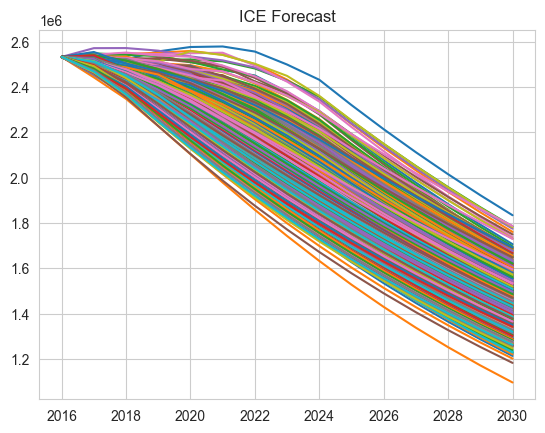

In [989]:
# Create dataframes that contain a column for each simulation and a row for each forecasted date
bev_forecast= pd.DataFrame(index=forecast_dates, columns=range(0, n_sim), dtype=float)
phev_forecast = pd.DataFrame(index=forecast_dates, columns=range(0, n_sim), dtype=float)
icev_forecast = pd.DataFrame(index=forecast_dates, columns=range(0, n_sim), dtype=float)

# Populate forecast with inital starting registrations
bev_forecast.iloc[0] = df.loc[t_max, 'BEV_Stock']
phev_forecast.iloc[0] = df.loc[t_max, 'PHEV_Stock']
icev_forecast.iloc[0] = df.loc[t_max, 'ICEV_Stock']

# Randomly sample retirement rates from posterior/prior predictive distributions
ice_retirement_rates_random = np.random.choice(retired_icev_prior_predictive.prior.retirement_rate.values.flatten(), size=(n_sim))
bev_retirement_rates_random = np.random.choice(retired_bev_prior_predictive.prior.retirement_rate.values.flatten(), size=(n_sim))
phev_retirement_rates_random = np.random.choice(retired_phev_prior_predictive.prior.retirement_rate.values.flatten(), size=(n_sim))

# Making the forecasts by adding new registrations and removing retired vehicles
for i in range(1, len(forecast_dates)):
    bev_forecast.loc[forecast_dates[i]] = bev_forecast.loc[forecast_dates[i-1]] + new_bev_forecast.loc[forecast_dates[i]] - (bev_retirement_rates_random * bev_forecast.loc[forecast_dates[i-1]])
    phev_forecast.loc[forecast_dates[i]] = phev_forecast.loc[forecast_dates[i-1]] + new_phev_forecast.loc[forecast_dates[i]] - (phev_retirement_rates_random * phev_forecast.loc[forecast_dates[i-1]])
    icev_forecast.loc[forecast_dates[i]] = icev_forecast.loc[forecast_dates[i-1]] + new_icev_forecast.loc[forecast_dates[i]] - (ice_retirement_rates_random * icev_forecast.loc[forecast_dates[i-1]])

bev_forecast_lsoa = round(bev_forecast)
phev_forecast_lsoa = round(phev_forecast)
icev_forecast_lsoa = round(icev_forecast)

bev_forecast_lsoa.plot(legend=False, title='BEV Forecast')
phev_forecast_lsoa.plot(legend=False, title='PHEV Forecast')
icev_forecast_lsoa.plot(legend=False, title='ICE Forecast')

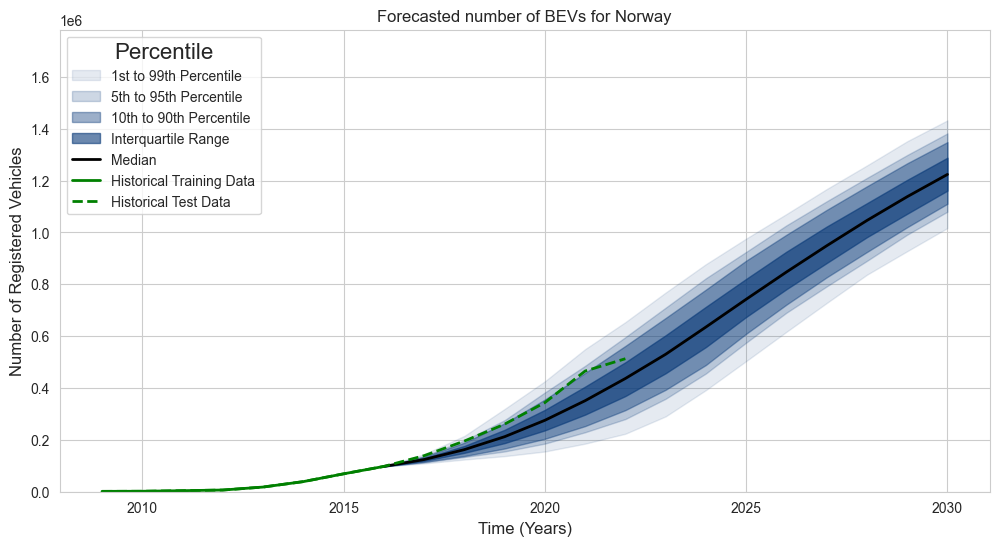

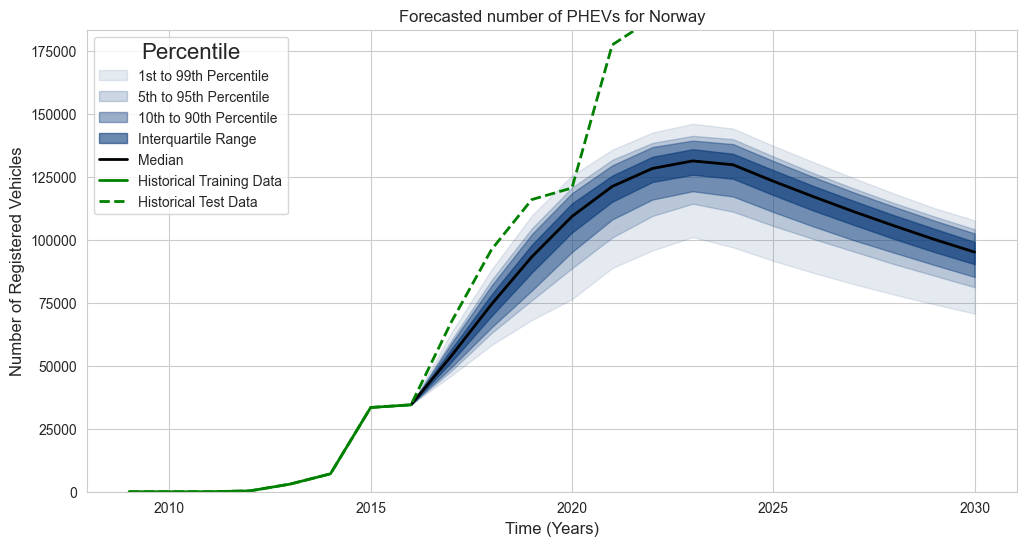

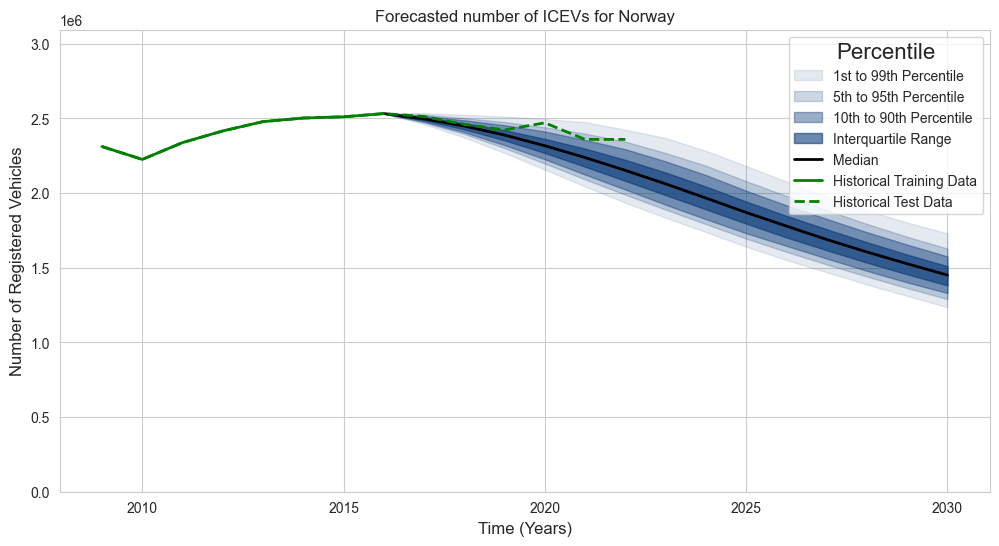

In [990]:
plot_probabilistic_vehicle_forecasts(bev_forecast, df['BEV_Stock'], 'BEV')
plot_probabilistic_vehicle_forecasts(phev_forecast, df['PHEV_Stock'], 'PHEV')
plot_probabilistic_vehicle_forecasts(icev_forecast, df['ICEV_Stock'], 'ICEV')

# Using ARIMA

In [1015]:
ev_sales_share.loc[forecast_dates]

Year
2016    0.277600
2017    0.357867
2018    0.438133
2019    0.518400
2020    0.598667
2021    0.678933
2022    0.759200
2023    0.839467
2024    0.919733
2025    1.000000
2026    1.000000
2027    1.000000
2028    1.000000
2029    1.000000
2030    1.000000
Name: ICEV_Market_Share_New_Registrations, dtype: float64

In [1017]:
ev_share_gp_samples

0         1         2         3         4         5         6    \
2016  0.277600  0.277600  0.277600  0.277600  0.277600  0.277600  0.277600   
2017  0.176489  0.193629  0.194032  0.205354  0.205379  0.209655  0.211103   
2018  0.070435  0.130151  0.150896  0.177319  0.179567  0.195355  0.208045   
2019  0.096566  0.162570  0.174289  0.202954  0.203536  0.211882  0.218042   
2020  0.093447  0.137014  0.161931  0.180914  0.223462  0.225677  0.239689   
2021  0.104148  0.202015  0.238814  0.241159  0.243956  0.252727  0.282351   
2022  0.384672  0.400533  0.408970  0.431563  0.445670  0.452346  0.455433   
2023  0.573946  0.610932  0.611035  0.624762  0.636500  0.639388  0.647756   
2024  0.776990  0.777897  0.788687  0.792827  0.799851  0.811883  0.815891   
2025  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2026  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2027  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2028  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2029  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2030  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

           7         8         9    ...       990       991       992  \
2016  0.277600  0.277600  0.277600  ...  0.277600  0.277600  0.277600   
2017  0.211584  0.215411  0.215611  ...  0.514247  0.516333  0.517389   
2018  0.213893  0.217211  0.230044  ...  0.724025  0.724096  0.734693   
2019  0.218551  0.219587  0.219873  ...  0.940073  0.945098  0.947742   
2020  0.251620  0.253360  0.260037  ...  0.981442  0.982118  0.982528   
2021  0.307977  0.329575  0.339273  ...  0.994860  0.995639  0.996293   
2022  0.465708  0.475701  0.476482  ...  0.992845  0.994180  0.994636   
2023  0.650656  0.652047  0.660394  ...  0.998321  0.998419  0.998491   
2024  0.816212  0.817145  0.817377  ...  0.998801  0.998871  0.998933   
2025  1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
2026  1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
2027  1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
2028  1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
2029  1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
2030  1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   

           993       994       995       996       997       998       999  
2016  0.277600  0.277600  0.277600  0.277600  0.277600  0.277600  0.277600  
2017  0.524335  0.526022  0.533043  0.533121  0.534896  0.544929  0.555590  
2018  0.737939  0.756959  0.760033  0.761249  0.787430  0.805565  0.841309  
2019  0.964586  0.966279  0.966623  0.970699  0.982345  0.992693  0.995036  
2020  0.984212  0.986543  0.987328  0.989360  0.992824  0.997616  0.997714  
2021  0.996511  0.996701  0.997158  0.997731  0.997830  0.998025  0.999722  
2022  0.995263  0.995762  0.996647  0.997522  0.997549  0.998866  0.999090  
2023  0.998543  0.998910  0.998990  0.999017  0.999232  0.999350  0.999589  
2024  0.998999  0.999157  0.999188  0.999382  0.999483  0.999600  0.999812  
2025  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
2026  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
2027  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
2028  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
2029  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
2030  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  

[15 rows x 1000 columns]

In [1018]:
new_vehicles_samples_df

0              1              2              3    \
2016  160363.000000  160363.000000  160363.000000  160363.000000   
2017  161899.367812  173895.118091  154823.075948  166288.667165   
2018  163419.011941  178082.414425  163241.029943  145944.003740   
2019  171687.254756  176653.839295  171283.253824  174689.358355   
2020  187148.946649  180896.235614  187662.770534  190474.508175   
2021  175563.612075  179031.591652  194130.723520  184985.691543   
2022  198485.773391  216497.591693  177267.465561  175564.825464   
2023  154015.823736  199363.612247  149027.116461  195153.642432   
2024  176006.903876  182792.627688  195112.147296  170377.865582   
2025  201970.516514  205334.155763  196337.041833  209725.701319   
2026  203830.273513  237237.268674  185762.735672  186673.725921   
2027  228706.758466  237013.815416  179377.445232  232268.321236   
2028  215597.797361  211626.168966  210307.007724  230931.483557   
2029  191868.901637  200009.746780  216961.041870  201969.251249   
2030  211319.794125  199255.453981  186374.068408  242088.535061   

                4              5              6              7    \
2016  160363.000000  160363.000000  160363.000000  160363.000000   
2017  170924.342184  175942.145057  178285.913471  168896.409207   
2018  166559.533781  162001.892358  168222.566958  184519.808294   
2019  163072.360587  178822.100172  163023.020714  177562.497539   
2020  171329.165678  169911.190865  175978.443221  177946.643143   
2021  166818.672731  182366.895955  181520.984773  185173.608135   
2022  183167.466297  188178.100076  200576.474843  156509.811727   
2023  159062.771026  144380.754760  169082.201443  188361.904001   
2024  221266.194284  174044.262427  187755.720767  211781.868714   
2025  220863.331360  256395.344950  205342.388511  216753.158721   
2026  223802.765401  206261.310440  189242.772681  166920.606929   
2027  189106.789448  203037.394150  165090.469428  215197.047901   
2028  223238.985420  203517.803835  167621.396932  192566.207313   
2029  229419.102195  242579.721492  200764.361234  214004.556189   
2030  258857.845673  214151.336312  239278.598470  220702.254344   

                8              9    ...            990            991  \
2016  160363.000000  160363.000000  ...  160363.000000  160363.000000   
2017  155218.314523  164511.613913  ...  182588.507931  169430.919273   
2018  174667.027143  154458.831046  ...  184511.405386  176217.394794   
2019  196995.930453  201685.791201  ...  175656.598288  161125.825982   
2020  180399.220482  176999.319749  ...  170716.179868  213553.855118   
2021  206530.167387  194151.412794  ...  177264.612073  179628.685272   
2022  162322.224792  180116.368989  ...  170659.366506  172661.130184   
2023  211041.781785  222091.915159  ...  182812.142221  198438.604491   
2024  221108.687682  229818.205742  ...  195052.029417  160650.271284   
2025  209308.585471  214370.589092  ...  212816.424627  212774.540662   
2026  205828.141526  214200.966078  ...  198694.681592  216147.163083   
2027  139803.939364  142592.042049  ...  211155.844262  185229.957967   
2028  162913.693724  211473.431019  ...  184124.842172  211003.147687   
2029  203329.118196  246521.225584  ...  157097.859527  215586.441361   
2030  149831.840312  204476.302196  ...  203854.734555  198207.152212   

                992            993            994            995  \
2016  160363.000000  160363.000000  160363.000000  160363.000000   
2017  174201.513734  166559.120546  172629.510062  162132.043863   
2018  184372.113152  159725.129823  163395.526644  172243.535669   
2019  168416.542616  172825.061799  165394.653876  192232.005345   
2020  182689.760014  179420.449175  180352.077130  188734.649832   
2021  198659.804455  178916.717788  171568.165320  203891.508534   
2022  187962.532856  194300.051034  168768.864280  227789.694576   
2023  182274.670862  172844.695487  164636.633630  181822.663894   
2024  181994.346574  174903.690681  195506.075529  174814

In [1026]:
new_ev_forecast = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1))
new_icev_forecast = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1))
new_bev_forecast = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1))
new_phev_forecast = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1))

# Simulate new registrations
for i in range(0, n_sim):
    new_ev_forecast[i+1] = ev_share_gp_samples[i].multiply(new_vehicles_samples_df[i], axis='rows')
    new_icev_forecast[i+1] = icev_share_gp_samples[i].multiply(new_vehicles_samples_df[i], axis='rows')
    new_bev_forecast[i+1] = bev_share_gp_samples[i].multiply(new_ev_forecast[i+1], axis='rows')
    new_phev_forecast[i+1] = phev_share_gp_samples[i].multiply(new_ev_forecast[i+1], axis='rows')

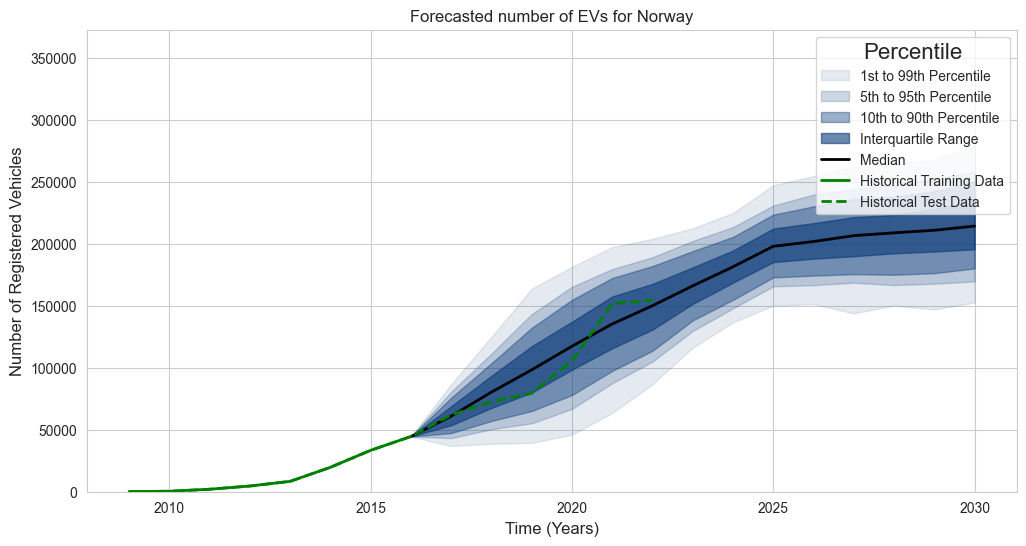

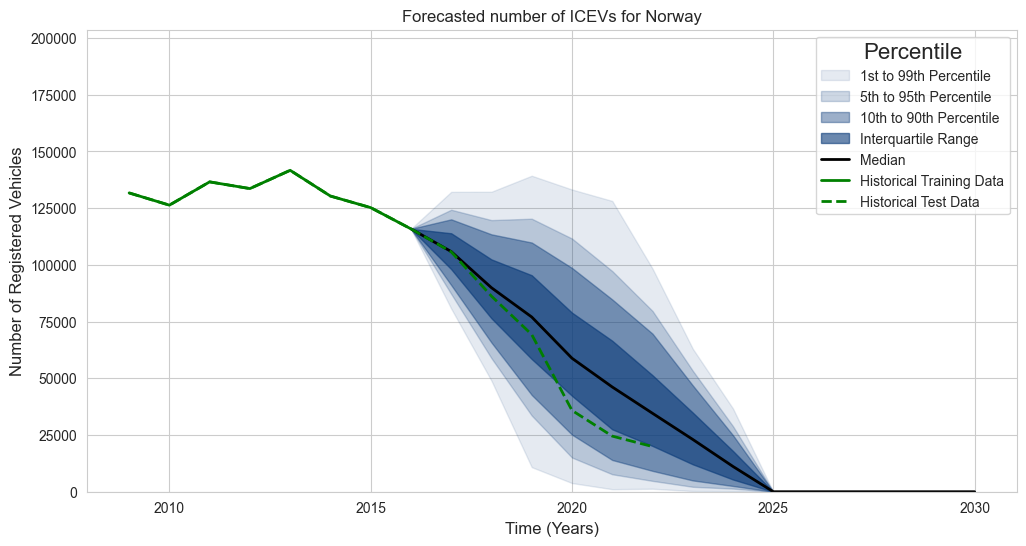

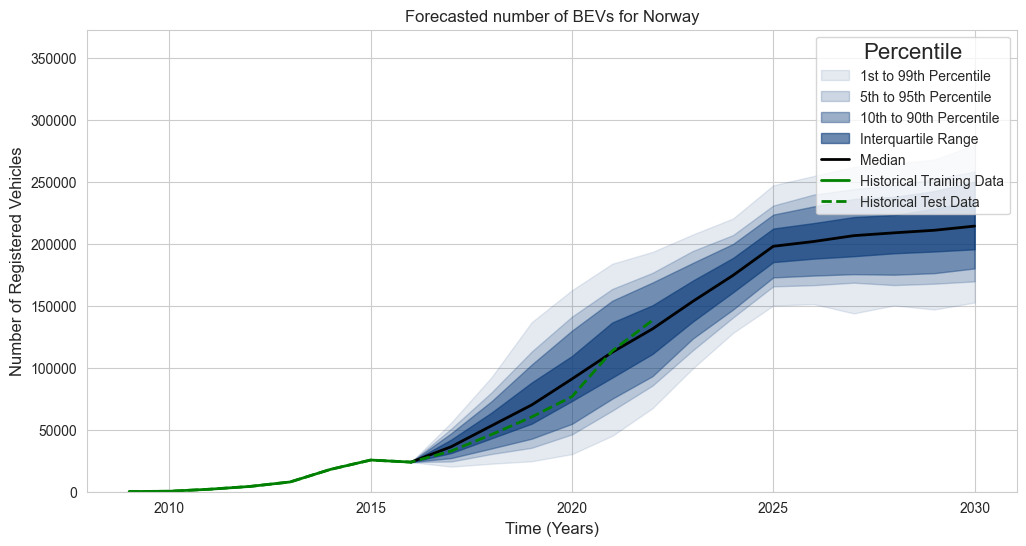

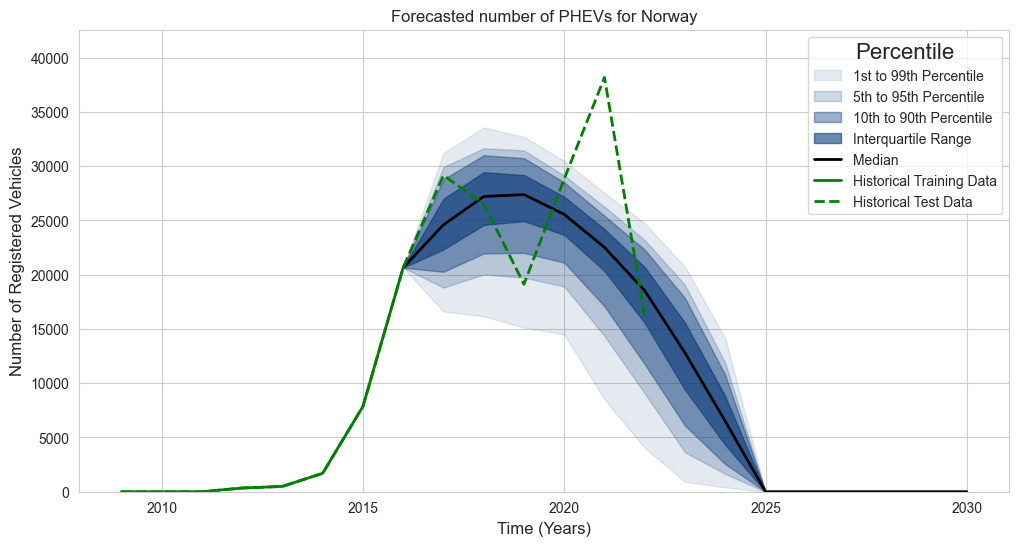

In [1027]:
plot_probabilistic_vehicle_forecasts(new_ev_forecast, df['EV_New_Registrations'], 'EV')
plot_probabilistic_vehicle_forecasts(new_icev_forecast, df['ICEV_New_Registrations'], 'ICEV')
plot_probabilistic_vehicle_forecasts(new_bev_forecast, df['BEV_New_Registrations'], 'BEV')
plot_probabilistic_vehicle_forecasts(new_phev_forecast, df['PHEV_New_Registrations'], 'PHEV')

In [1012]:
new_vehicles_samples_df

0              1              2              3    \
2016  160363.000000  160363.000000  160363.000000  160363.000000   
2017  161899.367812  173895.118091  154823.075948  166288.667165   
2018  163419.011941  178082.414425  163241.029943  145944.003740   
2019  171687.254756  176653.839295  171283.253824  174689.358355   
2020  187148.946649  180896.235614  187662.770534  190474.508175   
2021  175563.612075  179031.591652  194130.723520  184985.691543   
2022  198485.773391  216497.591693  177267.465561  175564.825464   
2023  154015.823736  199363.612247  149027.116461  195153.642432   
2024  176006.903876  182792.627688  195112.147296  170377.865582   
2025  201970.516514  205334.155763  196337.041833  209725.701319   
2026  203830.273513  237237.268674  185762.735672  186673.725921   
2027  228706.758466  237013.815416  179377.445232  232268.321236   
2028  215597.797361  211626.168966  210307.007724  230931.483557   
2029  191868.901637  200009.746780  216961.041870  201969.251249   
2030  211319.794125  199255.453981  186374.068408  242088.535061   

                4              5              6              7    \
2016  160363.000000  160363.000000  160363.000000  160363.000000   
2017  170924.342184  175942.145057  178285.913471  168896.409207   
2018  166559.533781  162001.892358  168222.566958  184519.808294   
2019  163072.360587  178822.100172  163023.020714  177562.497539   
2020  171329.165678  169911.190865  175978.443221  177946.643143   
2021  166818.672731  182366.895955  181520.984773  185173.608135   
2022  183167.466297  188178.100076  200576.474843  156509.811727   
2023  159062.771026  144380.754760  169082.201443  188361.904001   
2024  221266.194284  174044.262427  187755.720767  211781.868714   
2025  220863.331360  256395.344950  205342.388511  216753.158721   
2026  223802.765401  206261.310440  189242.772681  166920.606929   
2027  189106.789448  203037.394150  165090.469428  215197.047901   
2028  223238.985420  203517.803835  167621.396932  192566.207313   
2029  229419.102195  242579.721492  200764.361234  214004.556189   
2030  258857.845673  214151.336312  239278.598470  220702.254344   

                8              9    ...            990            991  \
2016  160363.000000  160363.000000  ...  160363.000000  160363.000000   
2017  155218.314523  164511.613913  ...  182588.507931  169430.919273   
2018  174667.027143  154458.831046  ...  184511.405386  176217.394794   
2019  196995.930453  201685.791201  ...  175656.598288  161125.825982   
2020  180399.220482  176999.319749  ...  170716.179868  213553.855118   
2021  206530.167387  194151.412794  ...  177264.612073  179628.685272   
2022  162322.224792  180116.368989  ...  170659.366506  172661.130184   
2023  211041.781785  222091.915159  ...  182812.142221  198438.604491   
2024  221108.687682  229818.205742  ...  195052.029417  160650.271284   
2025  209308.585471  214370.589092  ...  212816.424627  212774.540662   
2026  205828.141526  214200.966078  ...  198694.681592  216147.163083   
2027  139803.939364  142592.042049  ...  211155.844262  185229.957967   
2028  162913.693724  211473.431019  ...  184124.842172  211003.147687   
2029  203329.118196  246521.225584  ...  157097.859527  215586.441361   
2030  149831.840312  204476.302196  ...  203854.734555  198207.152212   

                992            993            994            995  \
2016  160363.000000  160363.000000  160363.000000  160363.000000   
2017  174201.513734  166559.120546  172629.510062  162132.043863   
2018  184372.113152  159725.129823  163395.526644  172243.535669   
2019  168416.542616  172825.061799  165394.653876  192232.005345   
2020  182689.760014  179420.449175  180352.077130  188734.649832   
2021  198659.804455  178916.717788  171568.165320  203891.508534   
2022  187962.532856  194300.051034  168768.864280  227789.694576   
2023  182274.670862  172844.695487  164636.633630  181822.663894   
2024  181994.346574  174903.690681  195506.075529  174814

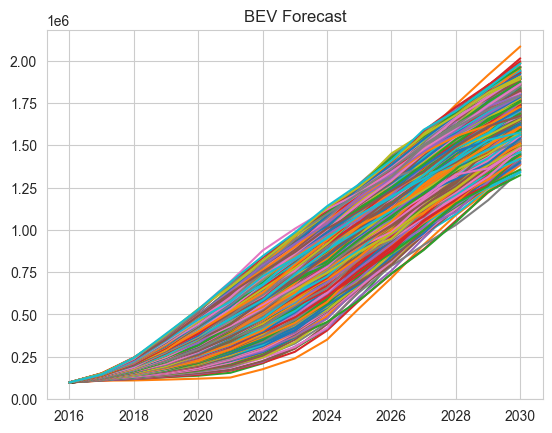

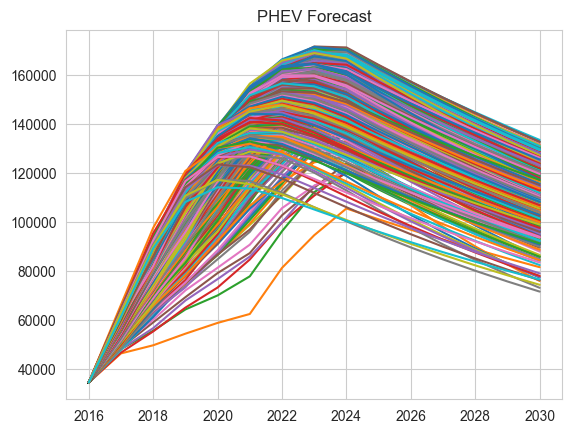

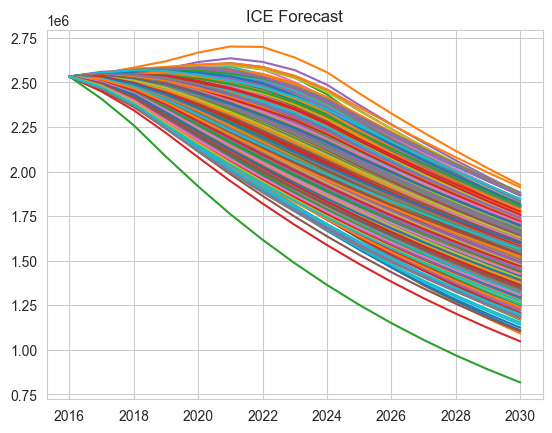

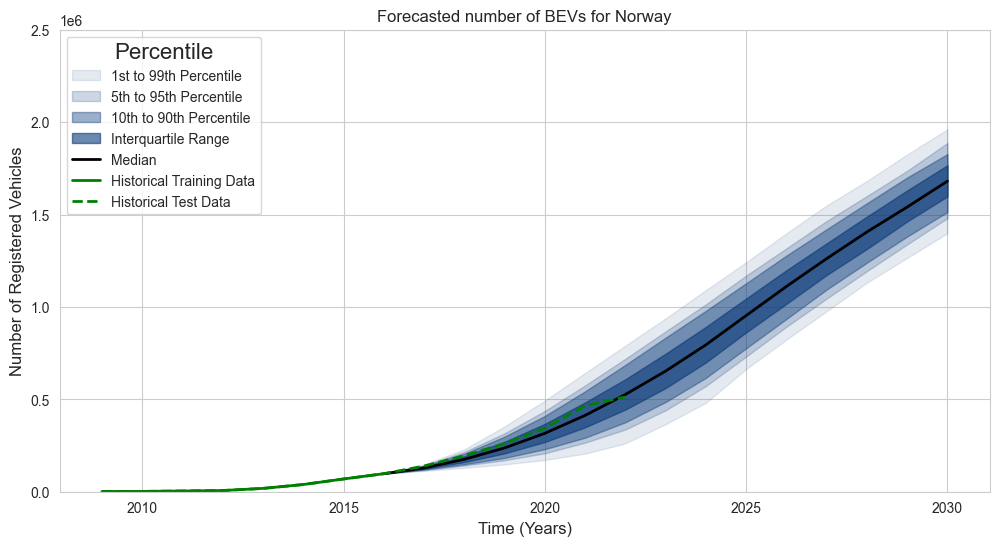

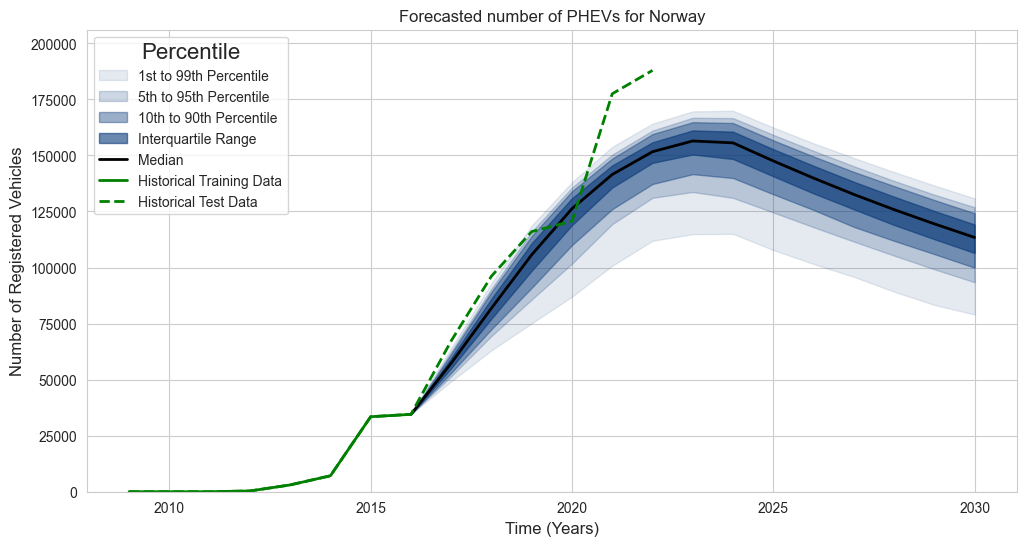

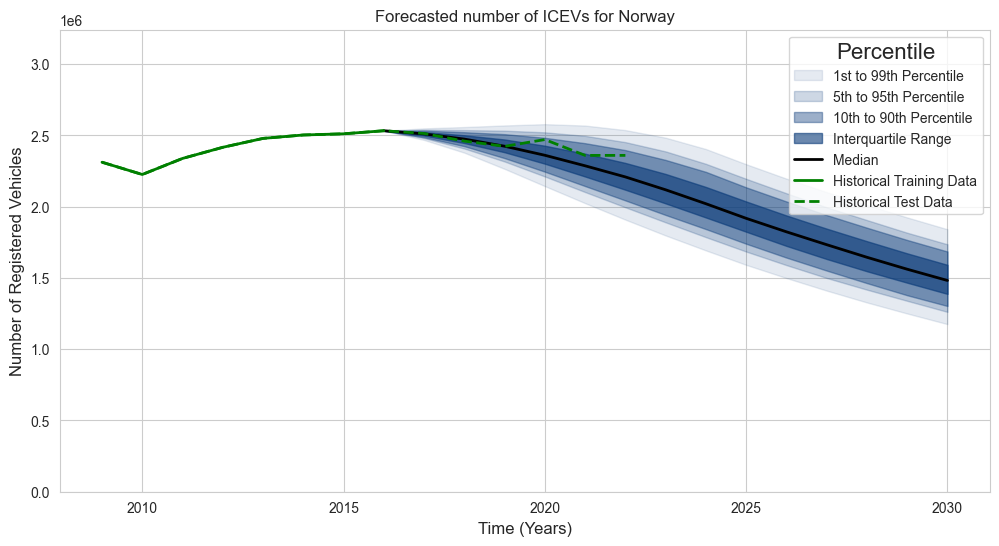

In [1028]:
# Create dataframes that contain a column for each simulation and a row for each forecasted date
bev_forecast= pd.DataFrame(index=forecast_dates, columns=range(0, n_sim), dtype=float)
phev_forecast = pd.DataFrame(index=forecast_dates, columns=range(0, n_sim), dtype=float)
icev_forecast = pd.DataFrame(index=forecast_dates, columns=range(0, n_sim), dtype=float)

# Populate forecast with inital starting registrations
bev_forecast.iloc[0] = df.loc[t_max, 'BEV_Stock']
phev_forecast.iloc[0] = df.loc[t_max, 'PHEV_Stock']
icev_forecast.iloc[0] = df.loc[t_max, 'ICEV_Stock']

# Randomly sample retirement rates from posterior/prior predictive distributions
ice_retirement_rates_random = np.random.choice(retired_icev_prior_predictive.prior.retirement_rate.values.flatten(), size=(n_sim))
bev_retirement_rates_random = np.random.choice(retired_bev_prior_predictive.prior.retirement_rate.values.flatten(), size=(n_sim))
phev_retirement_rates_random = np.random.choice(retired_phev_prior_predictive.prior.retirement_rate.values.flatten(), size=(n_sim))

# Making the forecasts by adding new registrations and removing retired vehicles
for i in range(1, len(forecast_dates)):
    bev_forecast.loc[forecast_dates[i]] = bev_forecast.loc[forecast_dates[i-1]] + new_bev_forecast.loc[forecast_dates[i]] - (bev_retirement_rates_random * bev_forecast.loc[forecast_dates[i-1]])
    phev_forecast.loc[forecast_dates[i]] = phev_forecast.loc[forecast_dates[i-1]] + new_phev_forecast.loc[forecast_dates[i]] - (phev_retirement_rates_random * phev_forecast.loc[forecast_dates[i-1]])
    icev_forecast.loc[forecast_dates[i]] = icev_forecast.loc[forecast_dates[i-1]] + new_icev_forecast.loc[forecast_dates[i]] - (ice_retirement_rates_random * icev_forecast.loc[forecast_dates[i-1]])

bev_forecast_lsoa = round(bev_forecast)
phev_forecast_lsoa = round(phev_forecast)
icev_forecast_lsoa = round(icev_forecast)

bev_forecast_lsoa.plot(legend=False, title='BEV Forecast')
phev_forecast_lsoa.plot(legend=False, title='PHEV Forecast')
icev_forecast_lsoa.plot(legend=False, title='ICE Forecast')

plot_probabilistic_vehicle_forecasts(bev_forecast, df['BEV_Stock'], 'BEV')
plot_probabilistic_vehicle_forecasts(phev_forecast, df['PHEV_Stock'], 'PHEV')
plot_probabilistic_vehicle_forecasts(icev_forecast, df['ICEV_Stock'], 'ICEV')